In [1]:
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC


#do cross fold validation
def crossVal(X,y,obj,fit_func,pred_func,k=10,numCores=10):
    loo = KFold(n_splits=k)
    loo.get_n_splits(X)
    #p = Pool(processes = numCores)
    argList = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        args = [X_train,X_test,y_train,y_test,fit_func,pred_func,obj]
        argList.append(args)
    #print('starting')
    #output = p.starmap(helper.runSplit,argList)
    output = [helper.runSplit(*x) for x in argList]
    y_true = flatten([x[0] for x in output])
    y_preds = flatten([x[1] for x in output])
    #print('finished')
    return r2_score(y_true, y_preds),y_preds,y_true

#imput matrix with half feature minimum
def imputeRowMin(arr,alt_min=2):
    #find the minimum non-zero value of each compound
    max_vals = []
    for c in arr.transpose():
        tmp = [x for x in c if x > 1e-3]
        if len(tmp) > 0:
            val = np.min(tmp)
        else:
            val = alt_min
        max_vals.append(val)
    #impute values 

    data_imp = np.zeros((len(arr),len(arr[0])))

    for c in range(len(arr[0])):
        for r in range(len(arr)):
            if arr[r,c] > 1e-3:
                data_imp[r,c] = arr[r,c]
            else:
                data_imp[r,c] = max_vals[c]/2
            if data_imp[r,c] < 1e-3:
                data_imp[r,c] = alt_min
    return data_imp

In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "06_25_2020_identified_features_peak_areas.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = [x for x in data.columns.values if "Area" in x]

#get molecule names
mol_names = data["Molecule Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "06252020_experiment_parameters.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

print(metadata_rel)
#create sample name, ventilator status linkage
vent_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"])
    sampName = row["Sample2"]
    if "B3" in sampName:
        sampName = sampName[:-13]
    if "es" in val:
        vent_dict[sampName] = 1
    elif "o" in val:
        vent_dict[sampName] = 0
        

print(np.sum(list(vent_dict.values()))," vent+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values()))," vent- samples")

#link vent status to sample in peak data
vent_status = []
for s in np.array(areaCols)[samp]:
    tmp = s.replace(" Area","").replace("pns_","")
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
    else:
        vent_status.append(-1)

print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = areaData[samp][samplesOfInterest]
samp_vent = np.array(vent_status)[samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

33  blanks
69  qc samples
442 research samples
170  d0 Covid+ Samples
                          Sample2                         Sample  batch  \
66   B1_WU350-013_d0_1681501b_2_2  B1_pWU350-013_d0_1681501b_2_2    1.0   
70   B1_WU350-014_d0_1681504b_2_1  B1_pWU350-014_d0_1681504b_2_1    1.0   
74   B1_WU350-021_d0_1681589b_2_1  B1_pWU350-021_d0_1681589b_2_1    1.0   
78   B1_WU350-029_d0_1681645b_2_1  B1_pWU350-029_d0_1681645b_2_1    1.0   
82   B1_WU350-031_d0_1681678b_2_2  B1_pWU350-031_d0_1681678b_2_2    1.0   
..                            ...                            ...    ...   
608  B6_WU350-256_d0_1686674b_1_4                            NaN    6.0   
610  B6_WU350-257_d0_1686724b_1_4                            NaN    6.0   
612  B6_WU350-259_d0_1686764b_1_4                            NaN    6.0   
613  B6_WU350-260_d0_1686770b_1_4                            NaN    6.0   
614  B6_WU350-261_d0_1686904b_1_4                            NaN    6.0   

     group     WU-350 WU day 

No handles with labels found to put in legend.


Text(0, 0.5, 'PC2')

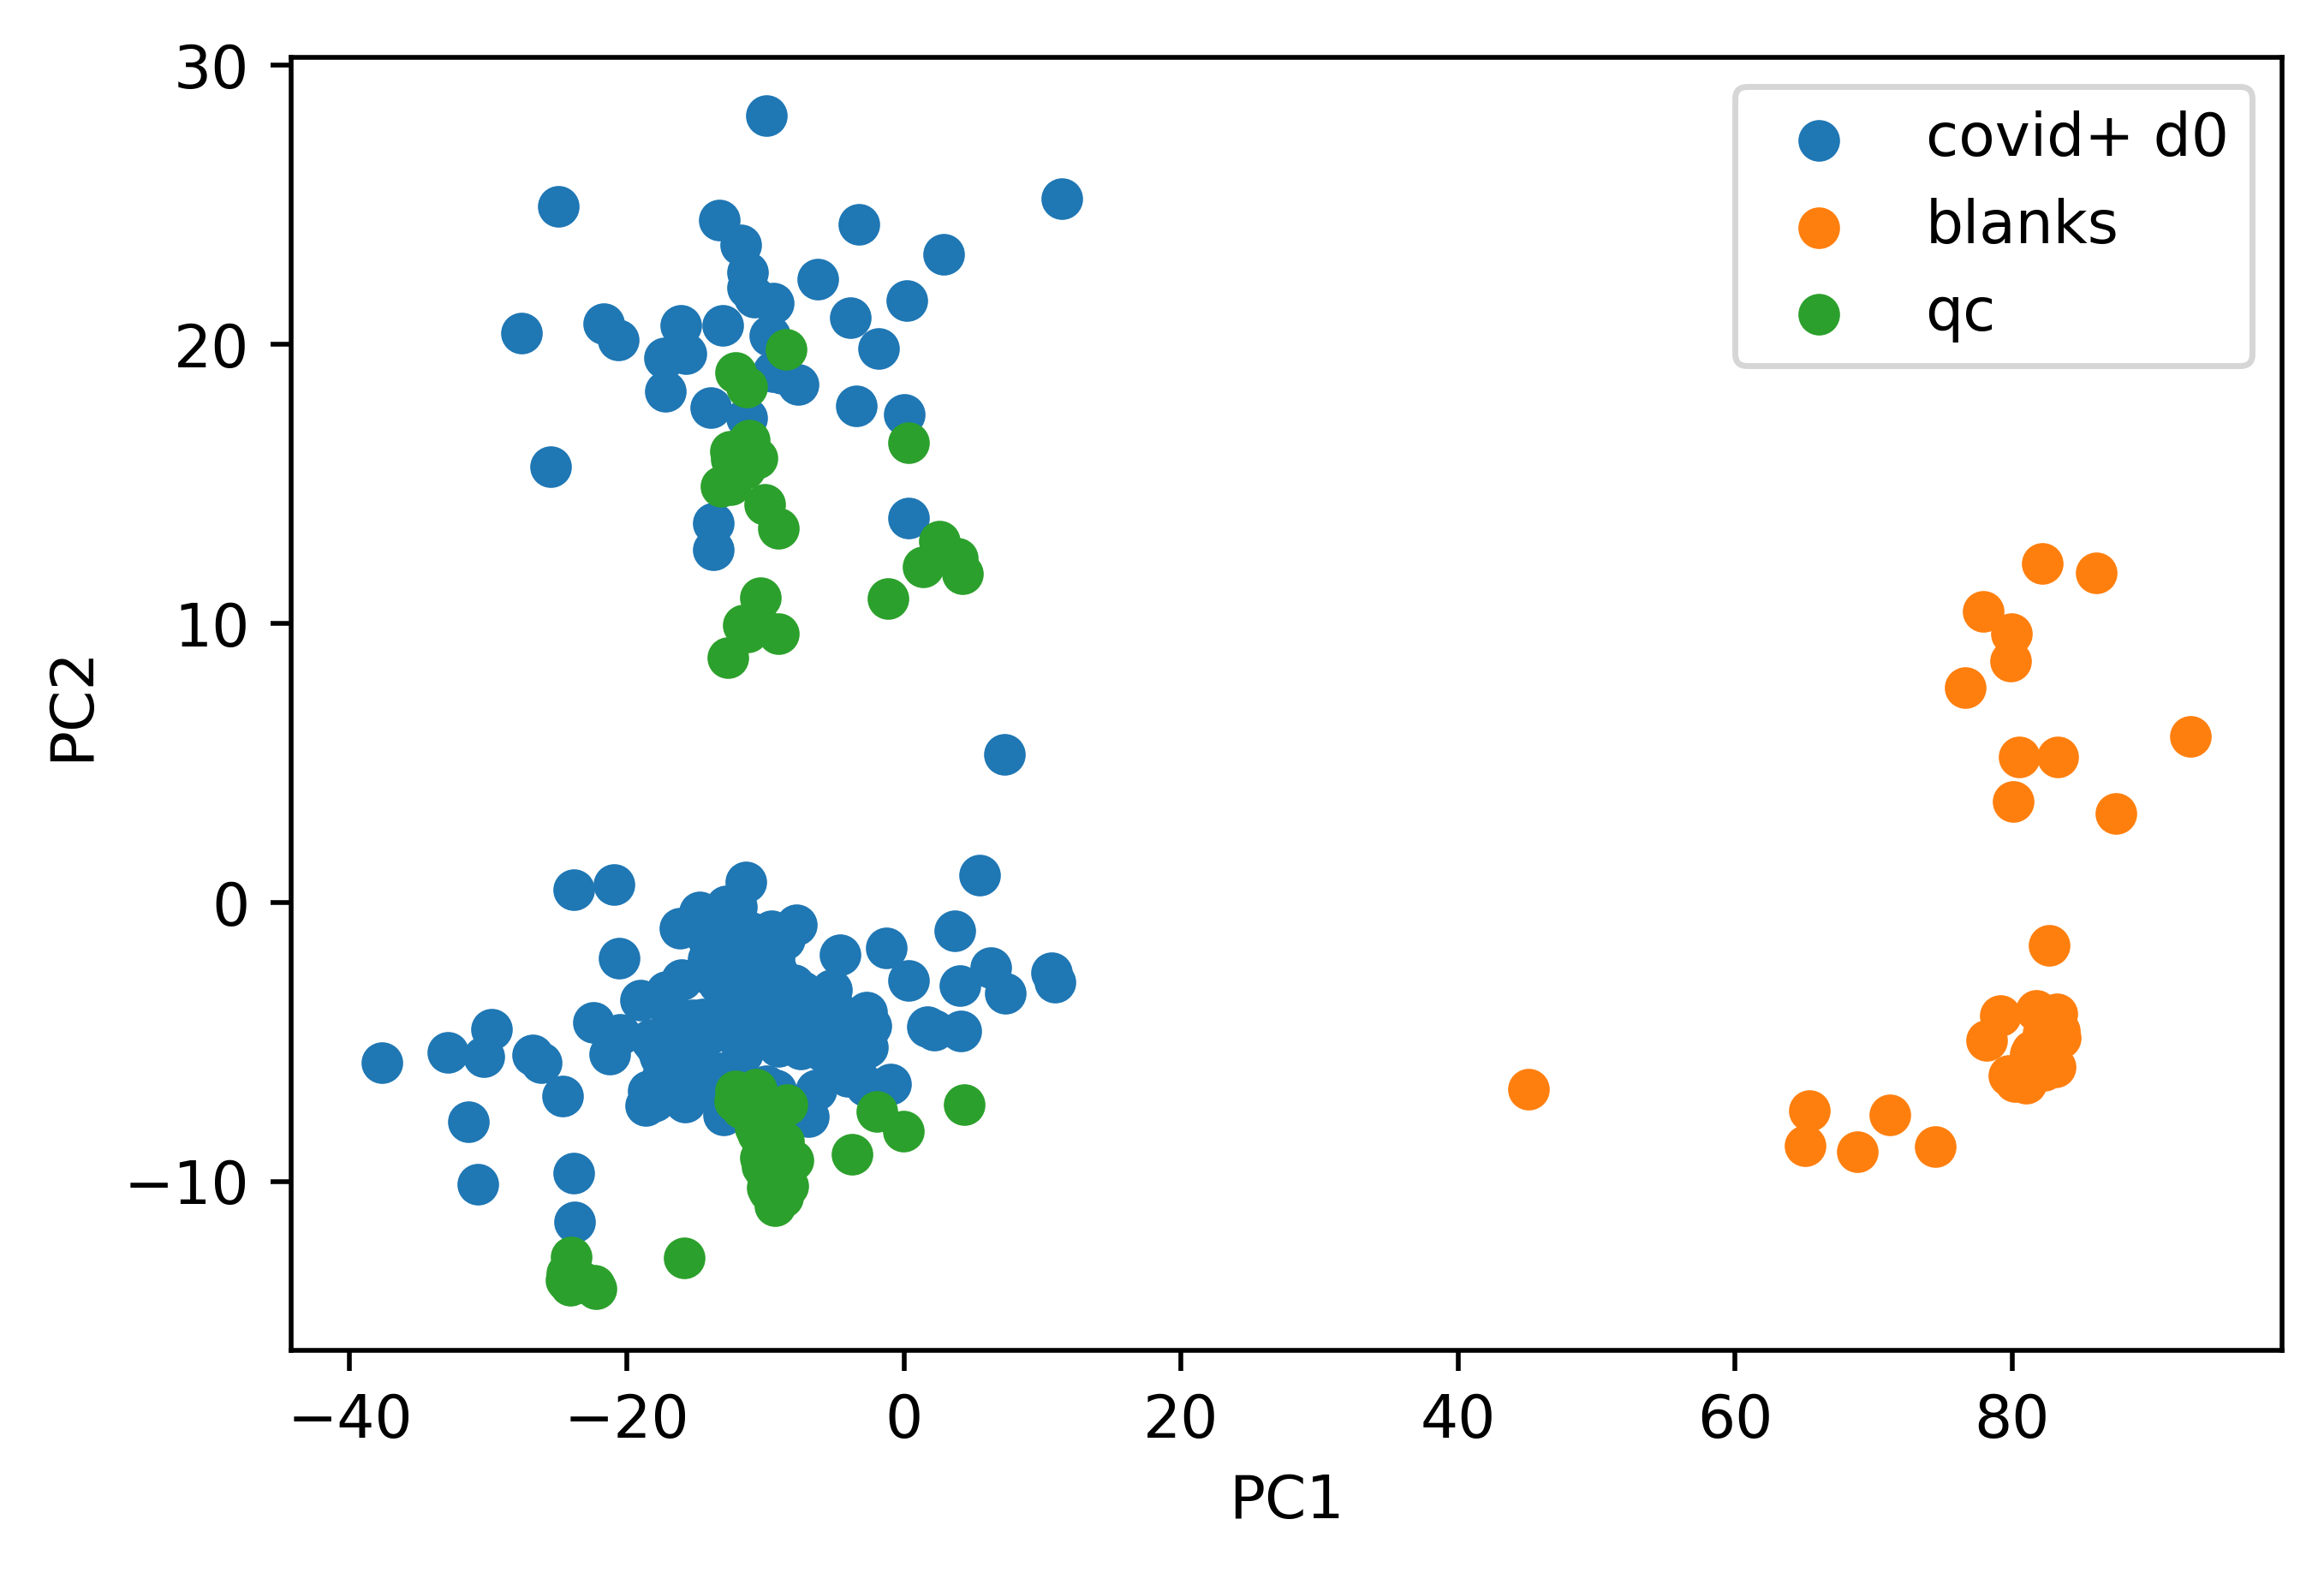

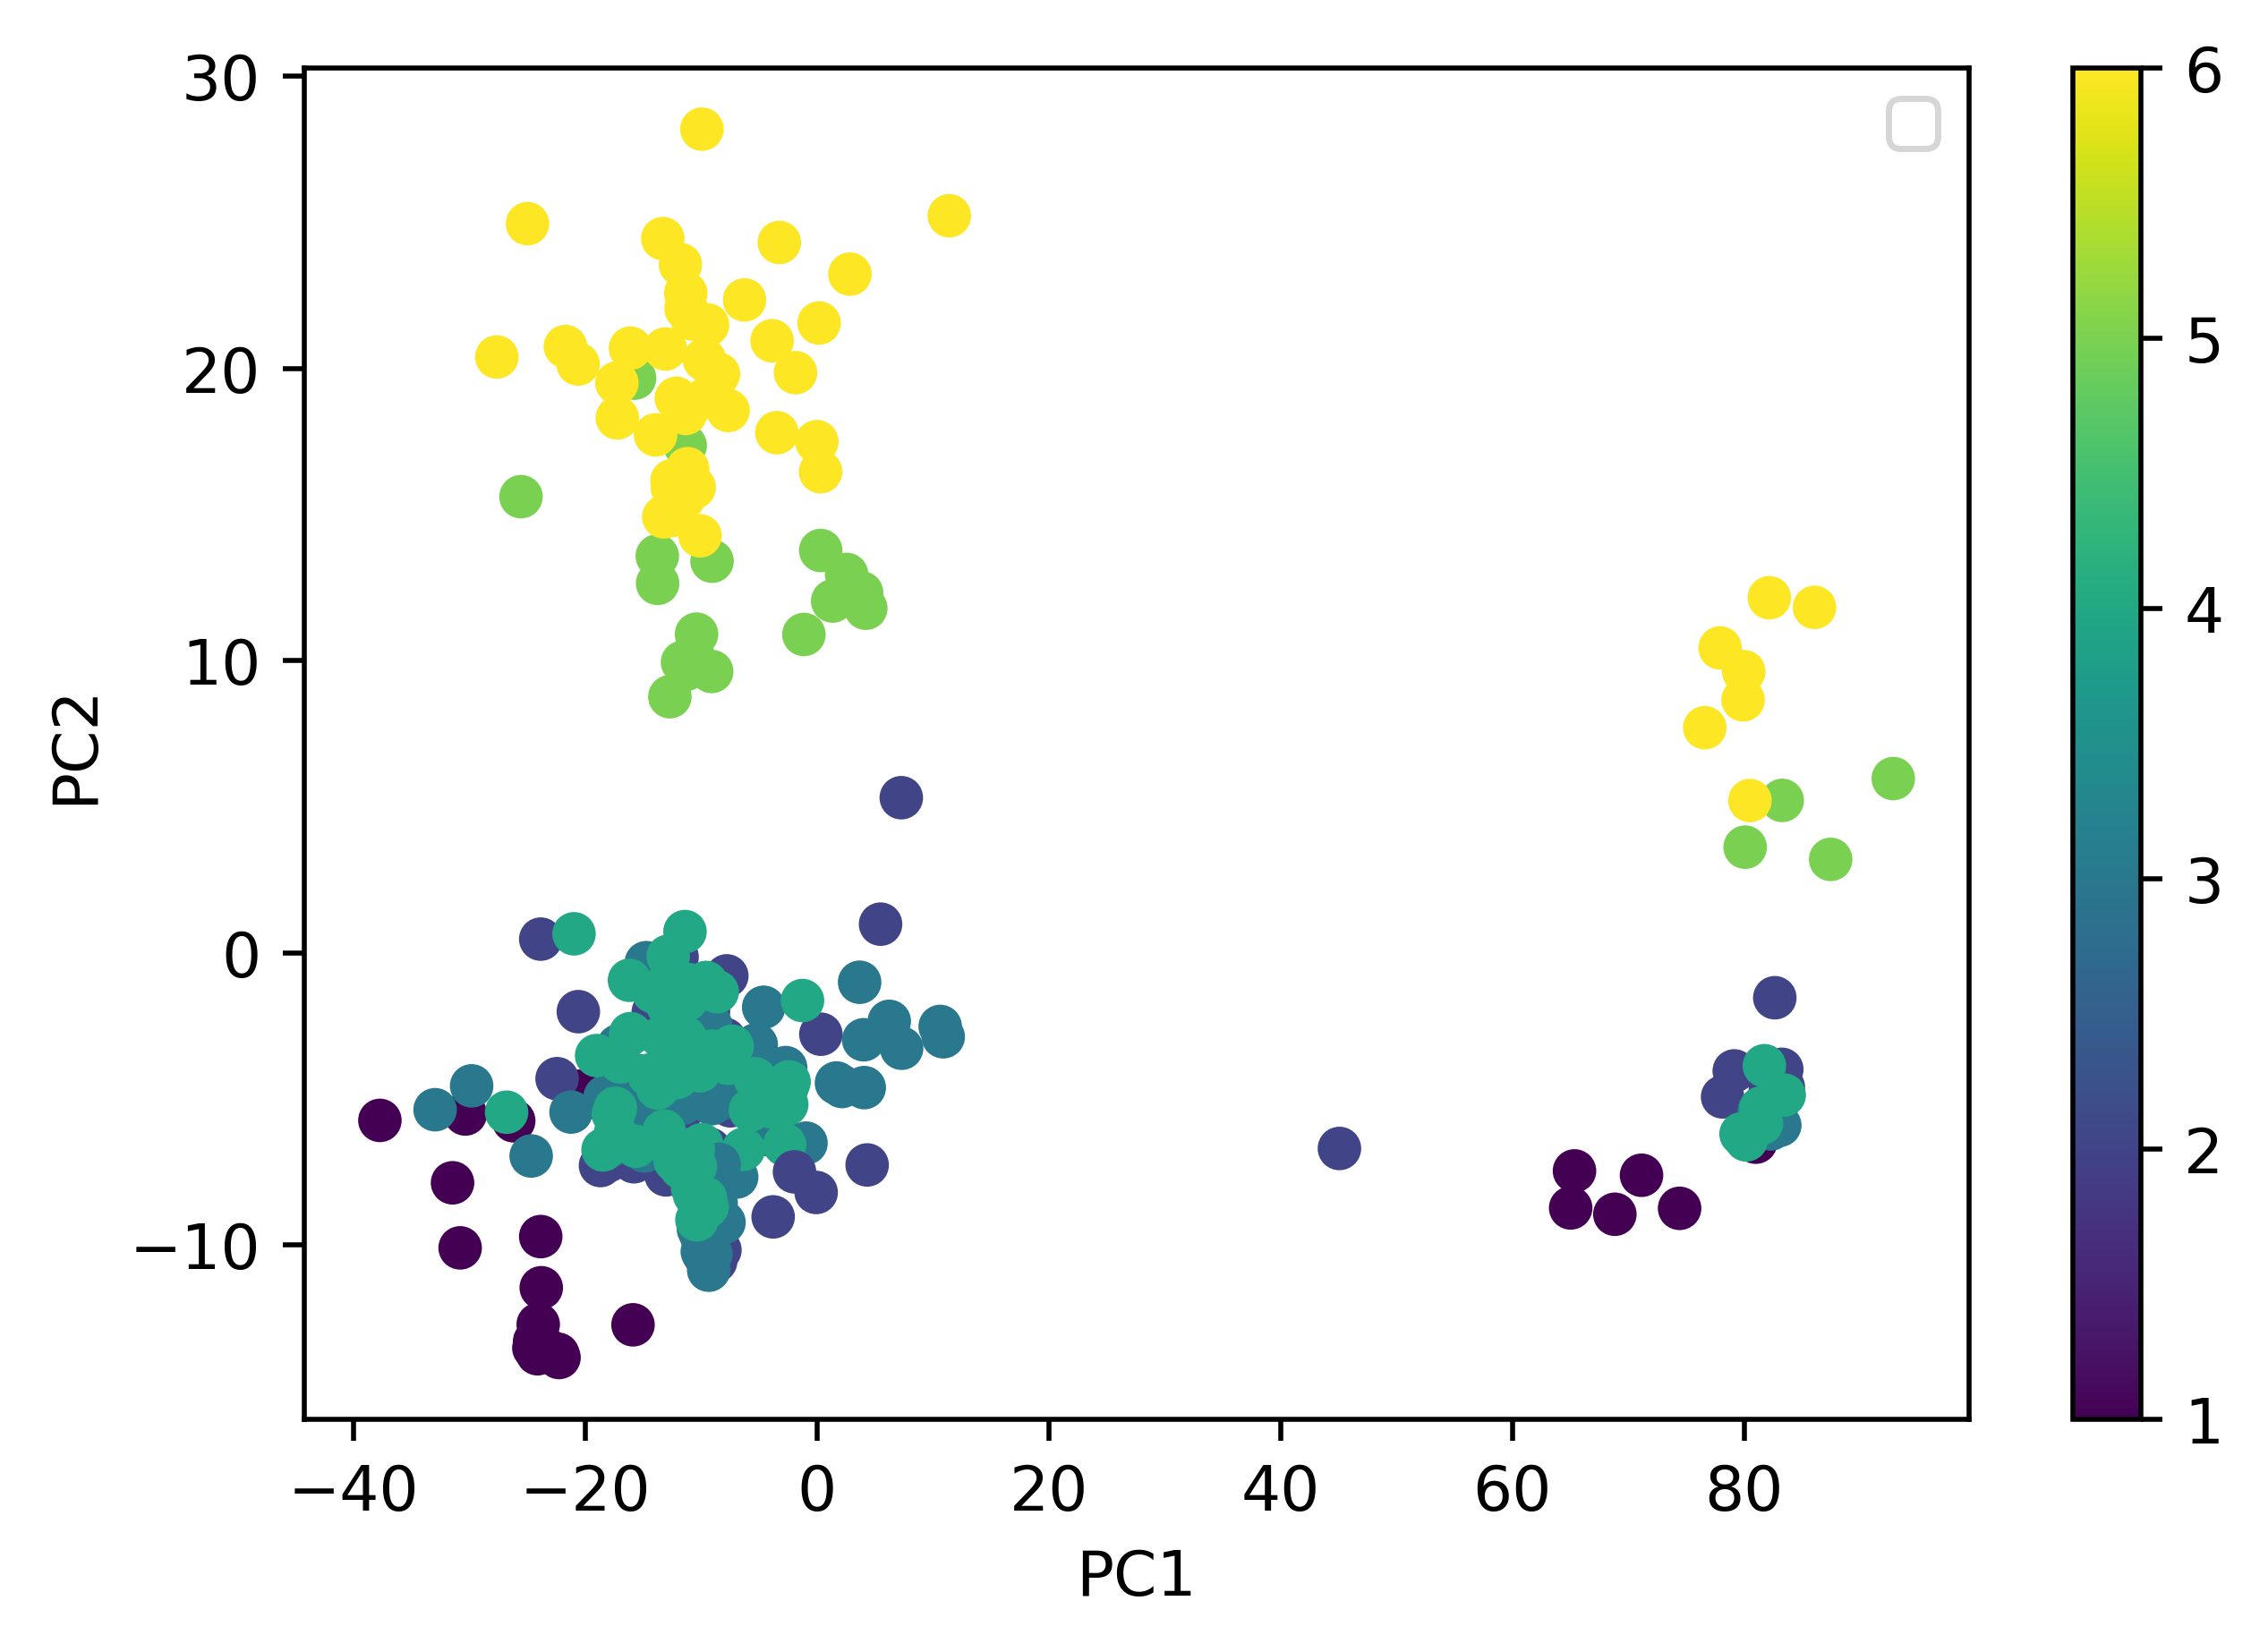

In [3]:
#visualize complete dataset

#first impute dataset
d_whole = np.concatenate((samp_int,blank_int,qc_int))
d_whole_imput = imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


No handles with labels found to put in legend.


Text(0, 0.5, 'PC2')

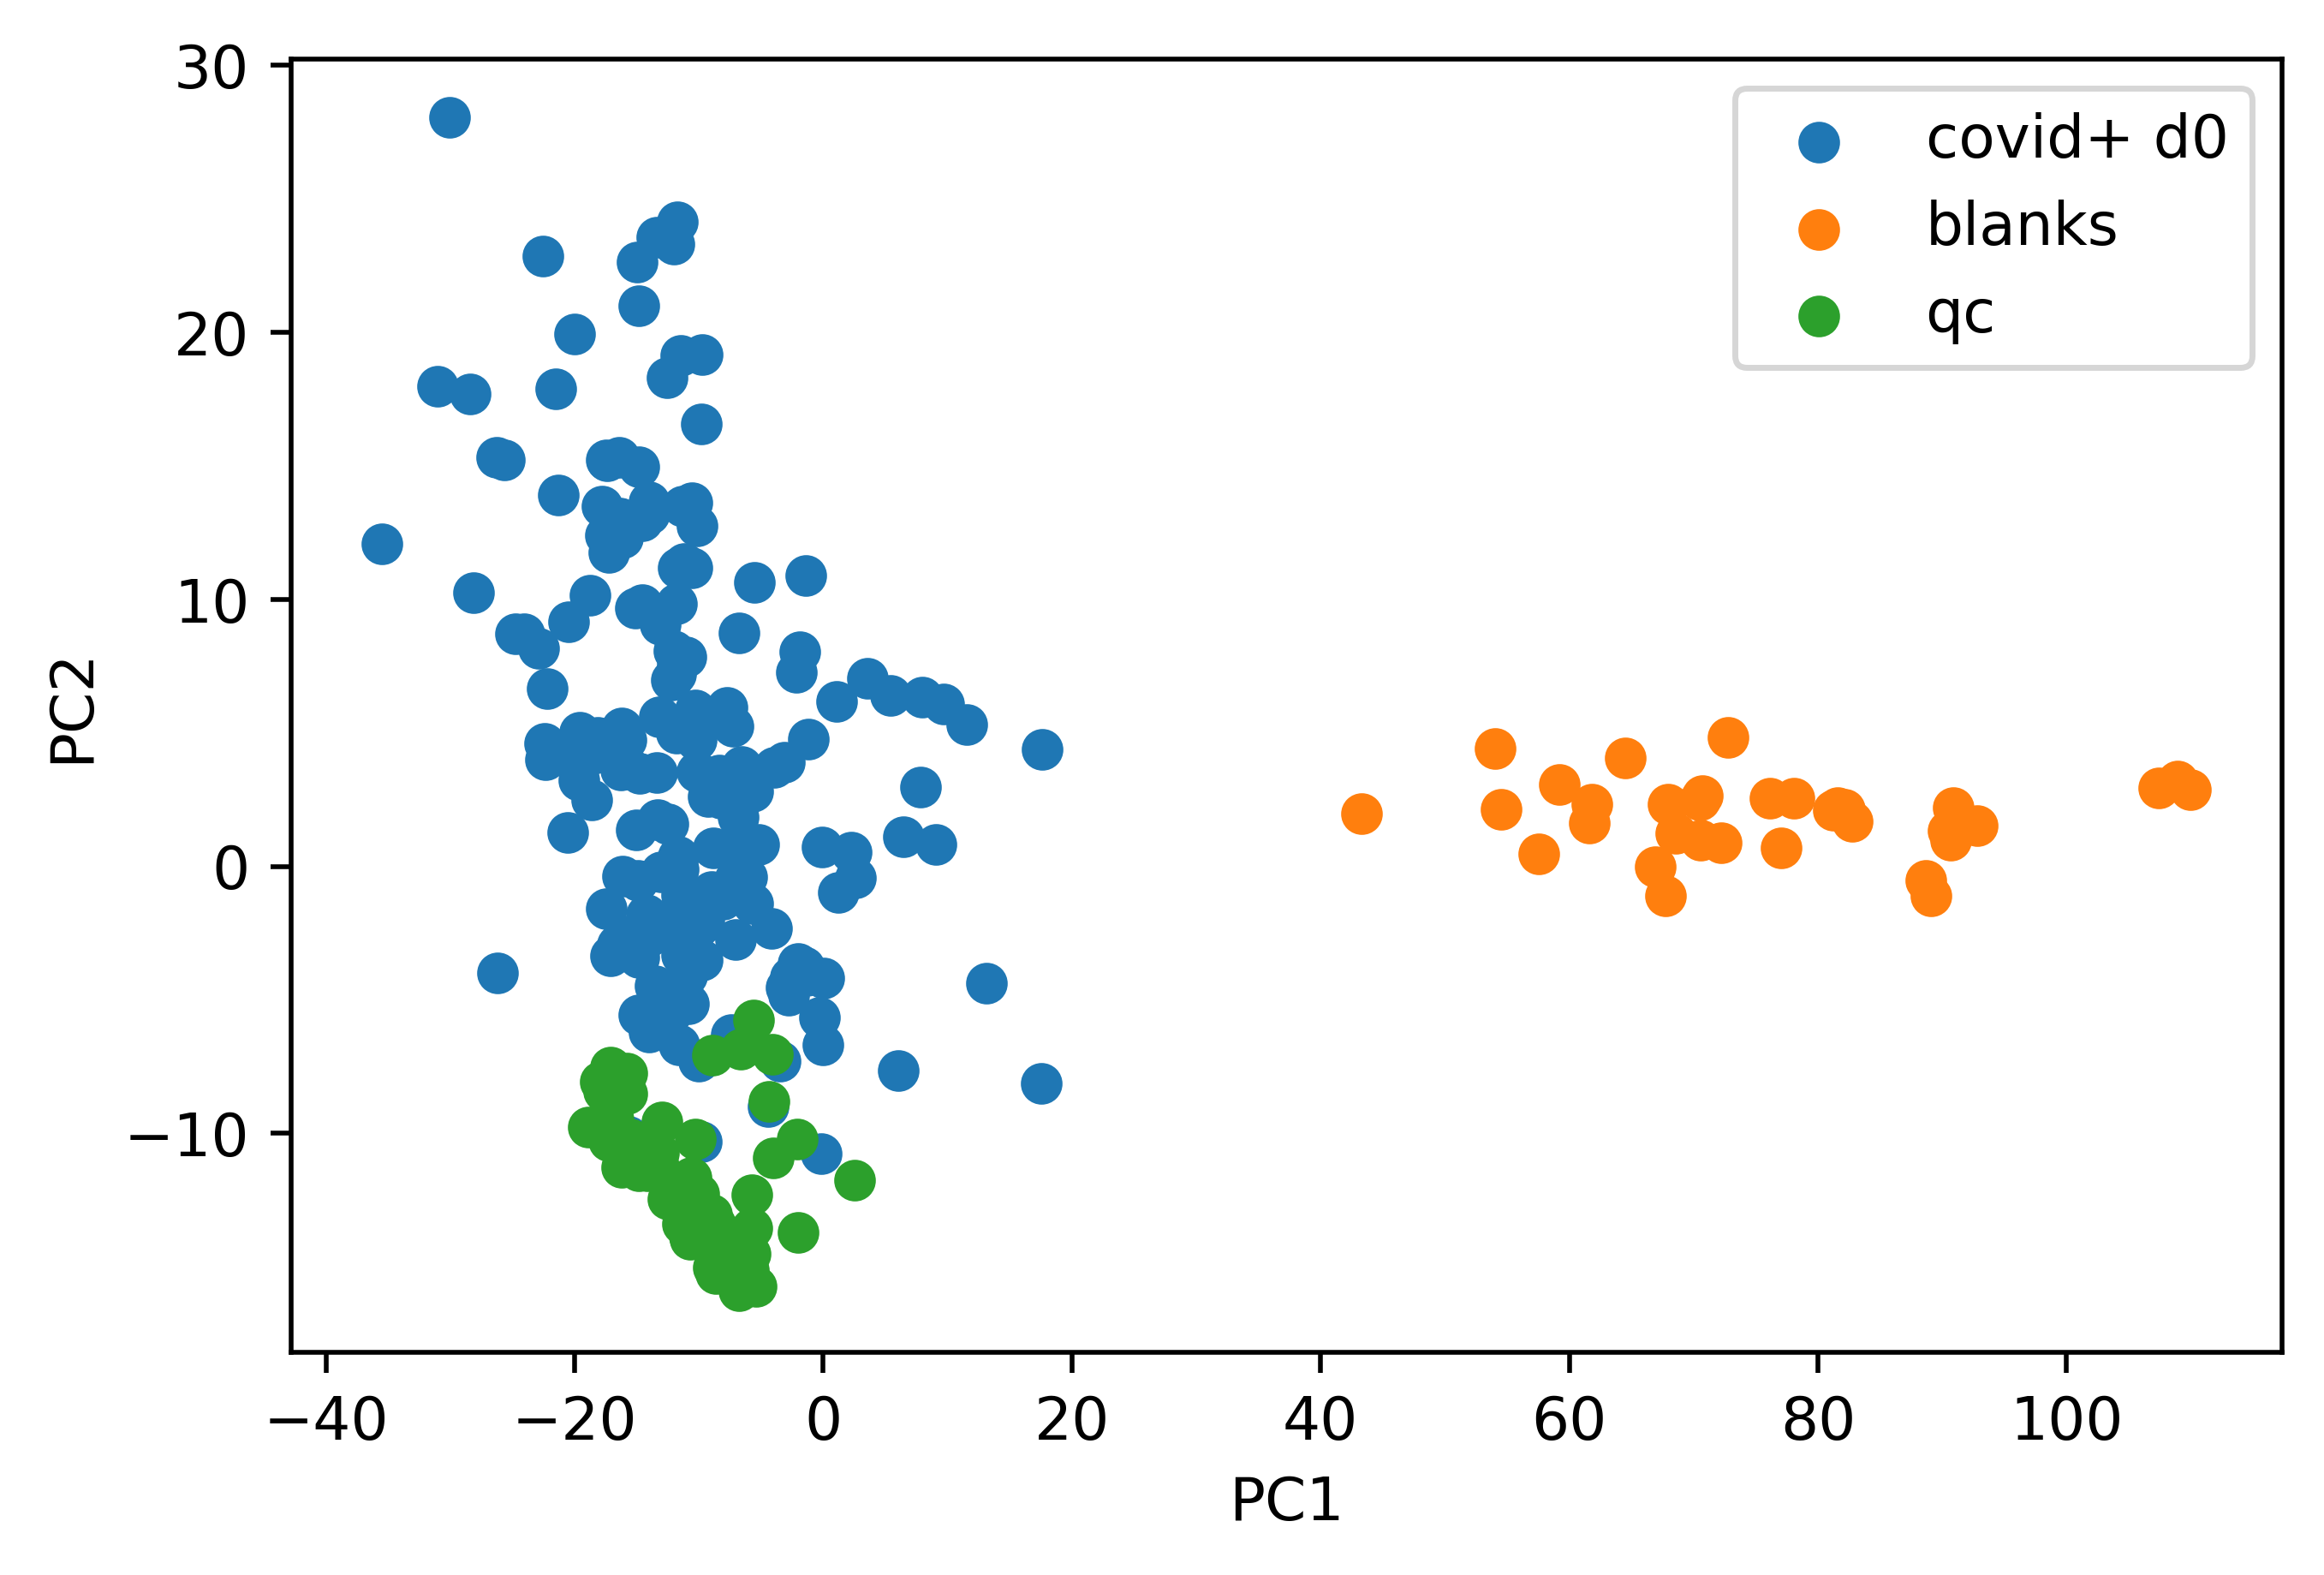

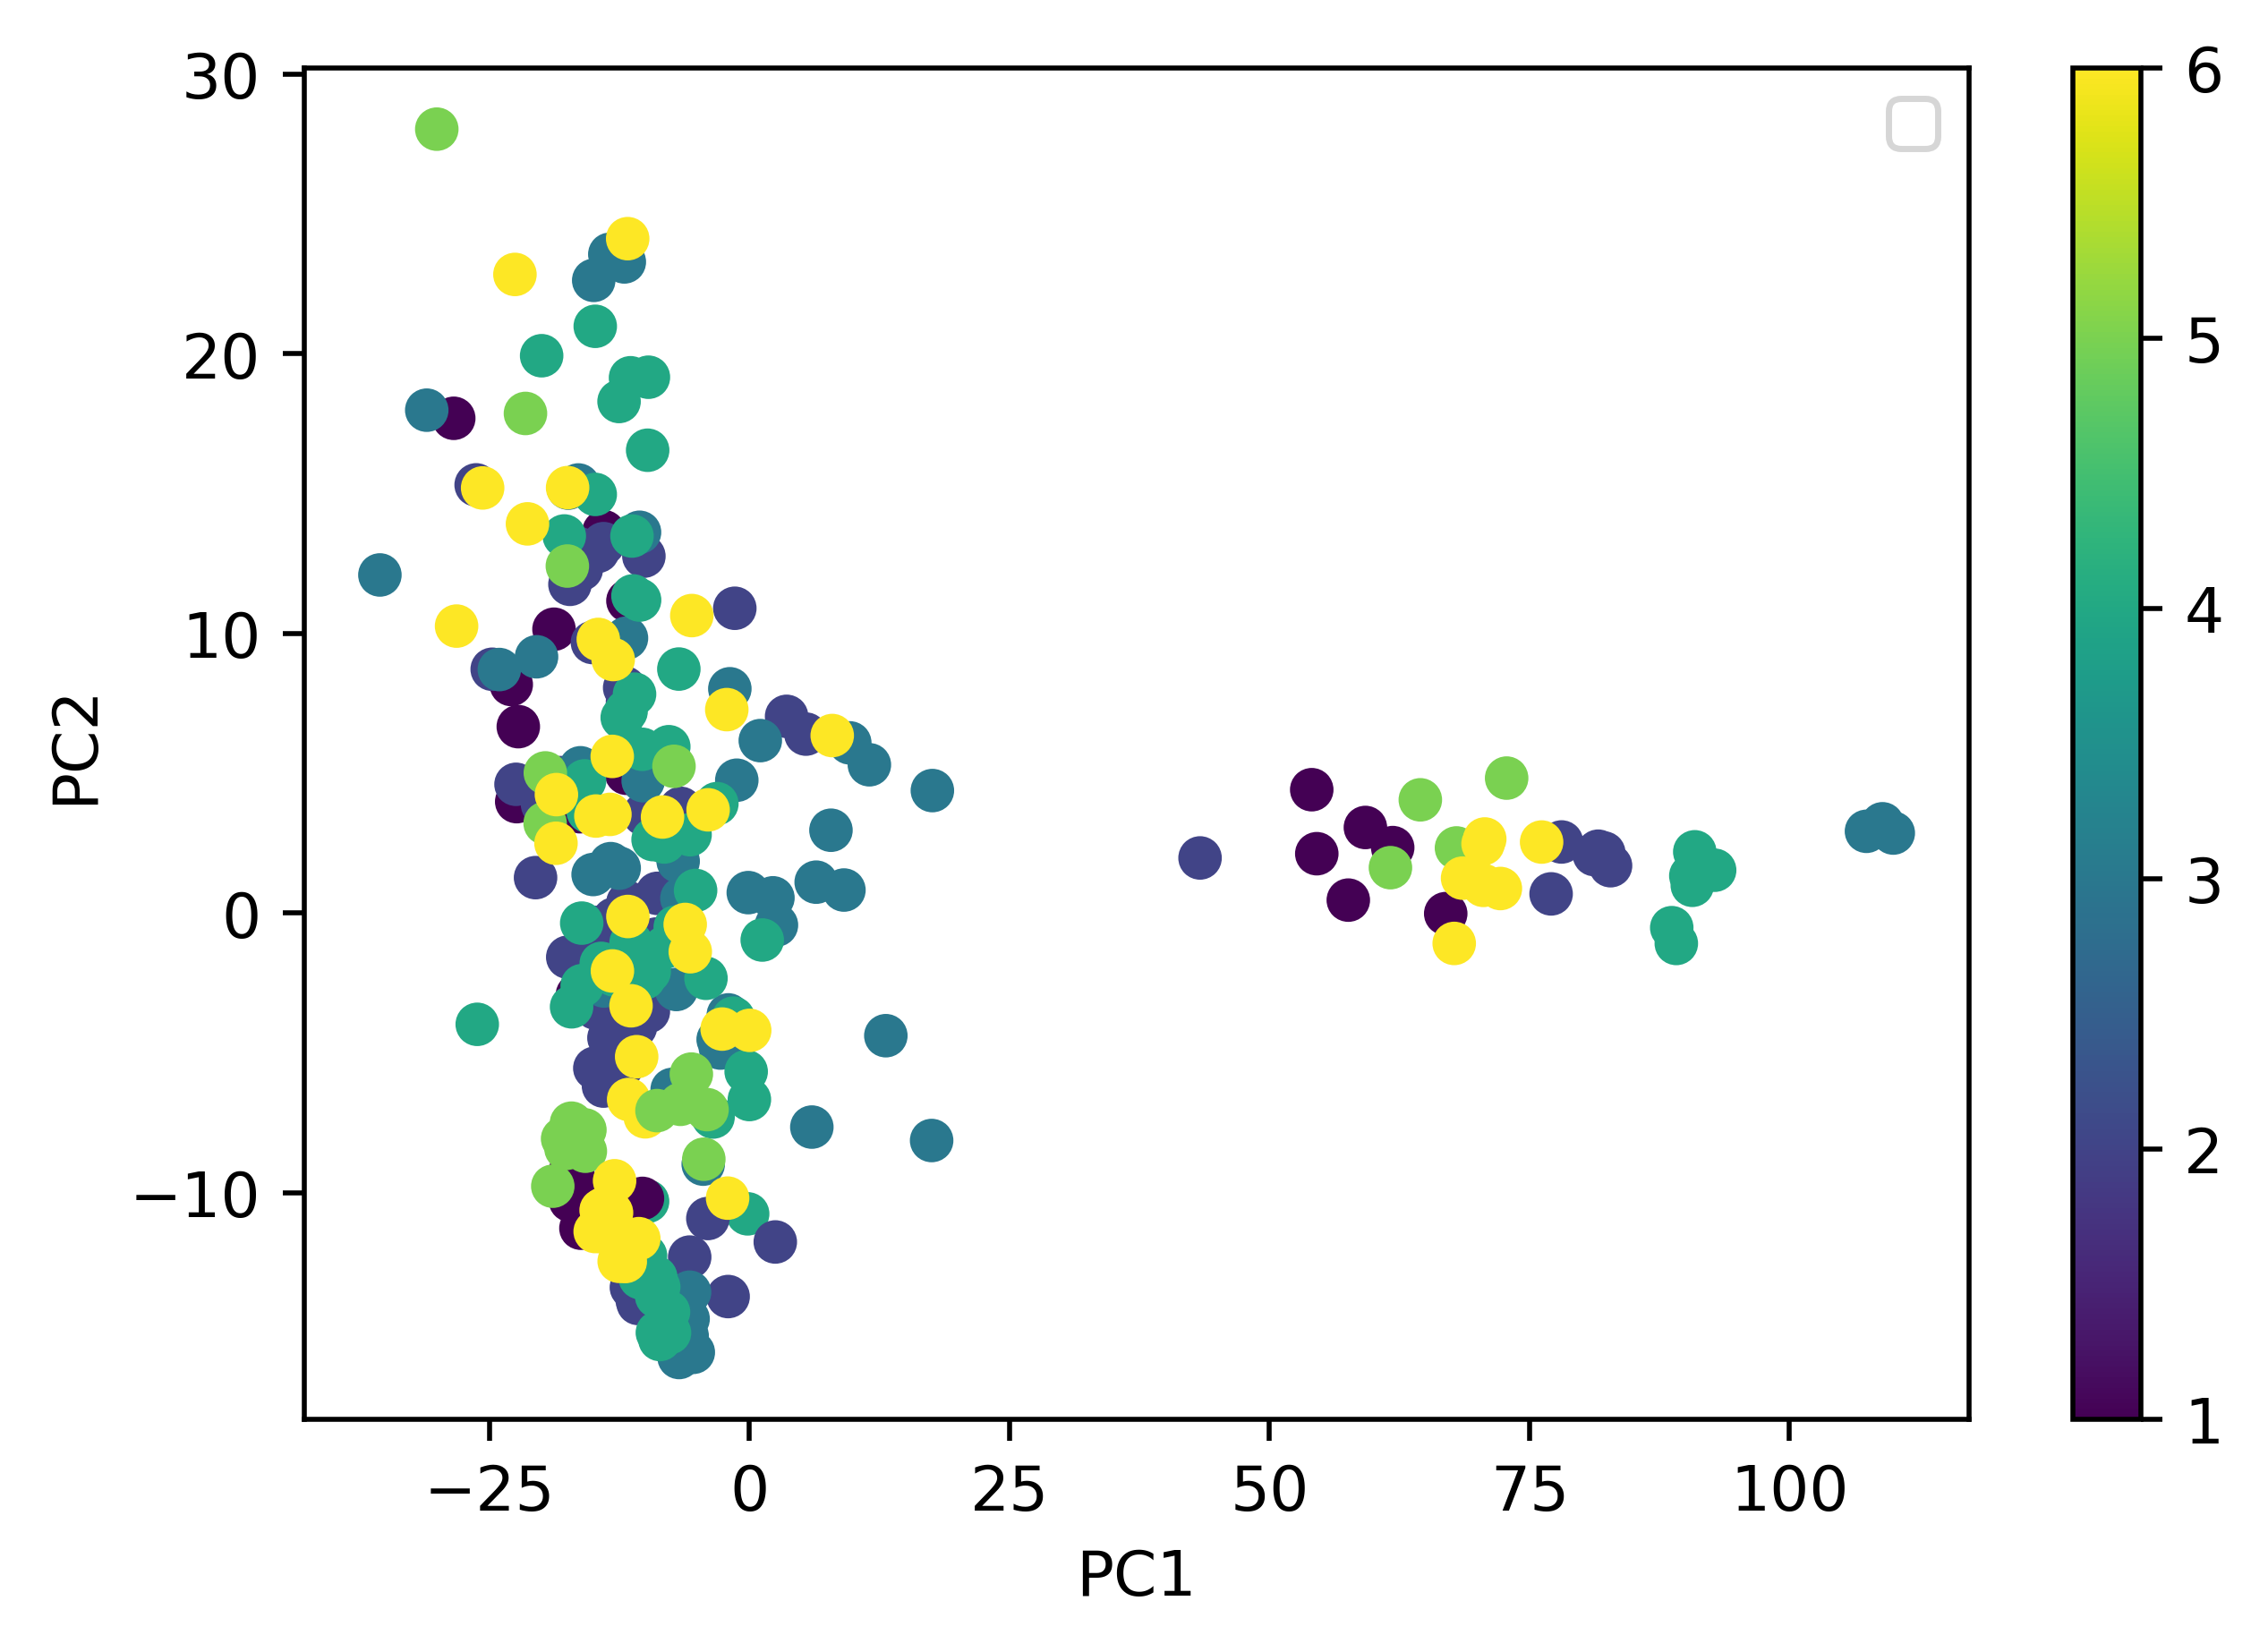

In [4]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),np.concatenate((samp_batch,blank_batch,qc_batch))).transpose().to_numpy()

#baseline to qcSamps
baseInt = [np.median(x) for x in d_whole_norm[len(samp_int)+len(blank_int):].transpose()]
d_whole_norm = np.array([[v-med for v,med in zip(row,baseInt)] for row in d_whole_norm])

#baseline to all samples
# baseInt = [np.median(x) for x in d_whole_norm.transpose()]
# d_whole_norm = np.array([[v-med for v,med in zip(row,baseInt)] for row in d_whole_norm])

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



Text(0, 0.5, 'PC2')

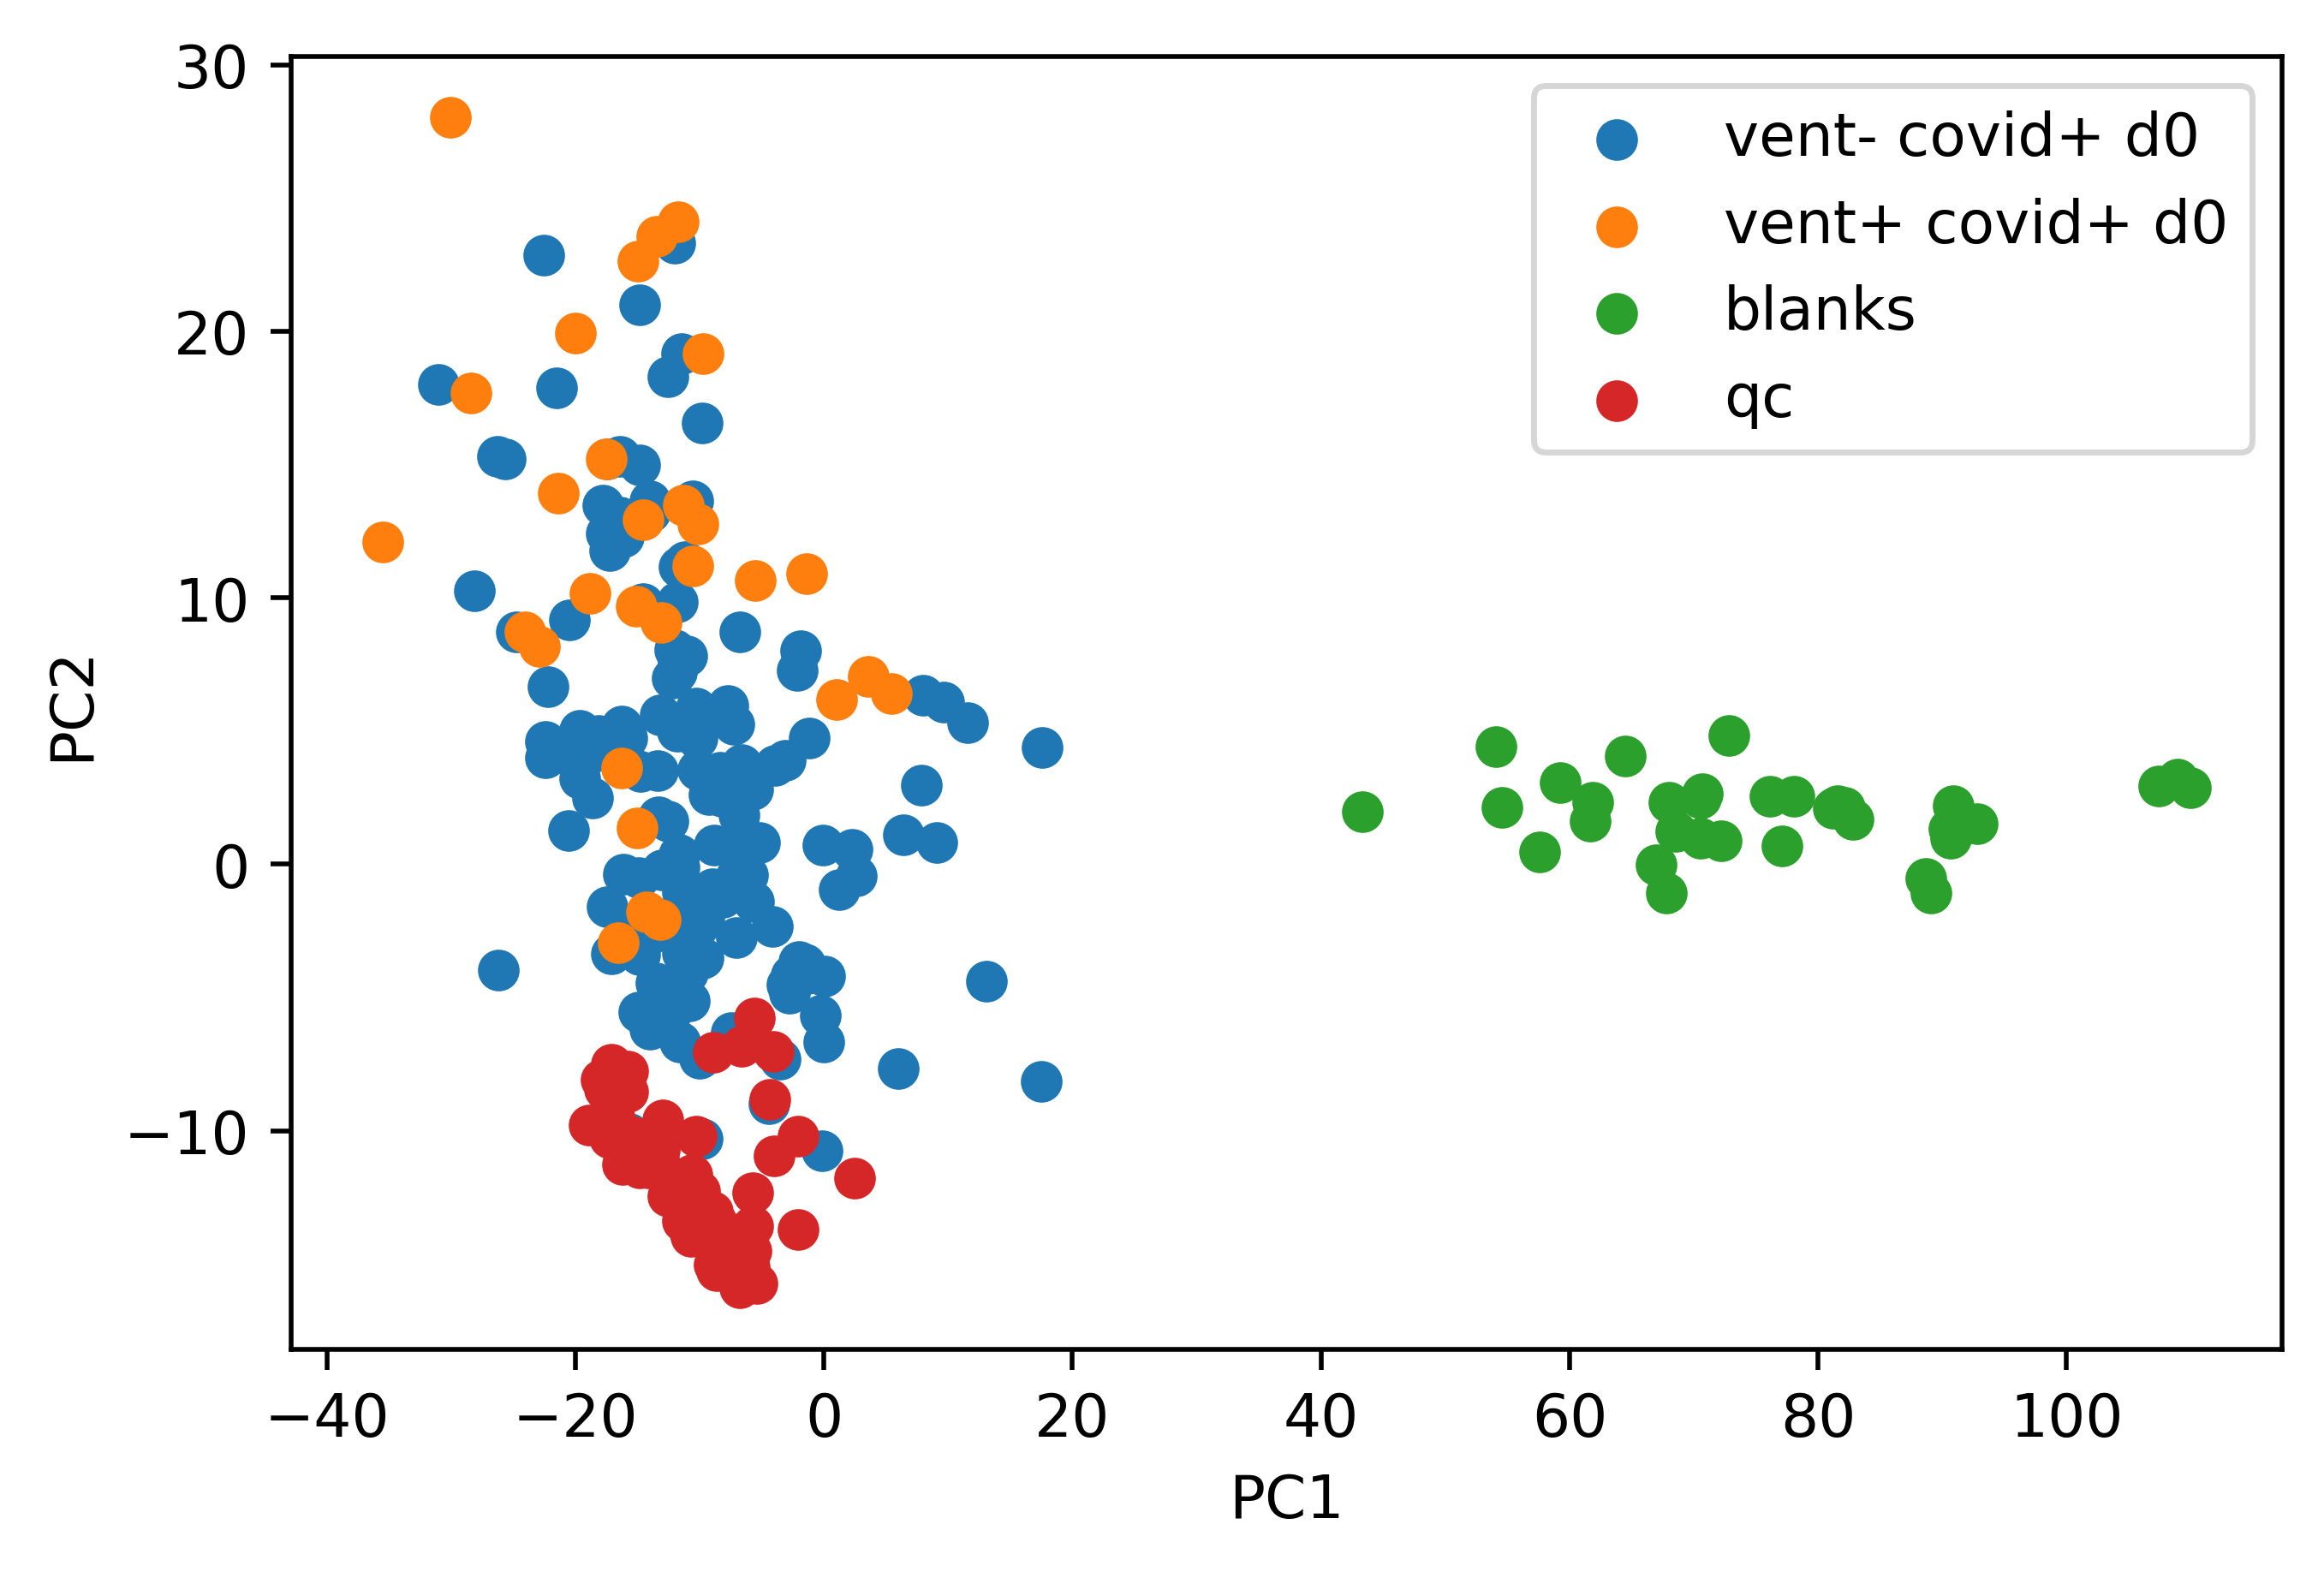

In [5]:
#now plot research samples by vent status
#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 0]
posSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="vent- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="vent+ covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



In [6]:
#create train and test sets for prediction model

#train batches on 1-4
#test on 5-6

trainBatches = [1,2,3,4]
testBatches = [5,6]


#get blanks for train/test
blank_train_index = [x for x in range(len(blank_batch)) if blank_batch[x] in trainBatches]
blank_test_index = [x for x in range(len(blank_batch)) if blank_batch[x] in testBatches]

blank_train_int = blank_int[blank_train_index]
blank_test_int = blank_int[blank_test_index]

blank_train_batch = blank_batch[blank_train_index]
blank_test_batch = blank_batch[blank_test_index]

#get samples for train/test
samp_train_index = [x for x in range(len(samp_batch)) if samp_batch[x] in trainBatches]
samp_test_index = [x for x in range(len(samp_batch)) if samp_batch[x] in testBatches]

samp_train_int = samp_int[samp_train_index]
samp_test_int = samp_int[samp_test_index]

samp_train_vent = samp_vent[samp_train_index]
samp_test_vent = samp_vent[samp_test_index]

samp_train_batch = samp_batch[samp_train_index]
samp_test_batch = samp_batch[samp_test_index]

#get qc for train/test

qc_train_index = [x for x in range(len(qc_batch)) if qc_batch[x] in trainBatches]
qc_test_index = [x for x in range(len(qc_batch)) if qc_batch[x] in testBatches]

qc_train_int = qc_int[qc_train_index]
qc_test_int = qc_int[qc_test_index] 

qc_train_batch = qc_batch[qc_train_index]
qc_test_batch = qc_batch[qc_test_index] 

#need to add vent and qcs

print("training examples: ",len(samp_train_int),"testing examples: ",len(samp_test_int))
print("training vent+ examples:, ",len([x for x in samp_train_vent if x == 1]),
      "training vent- examples:, ",len([x for x in samp_train_vent if x == 0]))
print("testing vent+ examples:, ",len([x for x in samp_test_vent if x == 1]),
      "testing vent- examples:, ",len([x for x in samp_test_vent if x == 0]))

training examples:  131 testing examples:  35
training vent+ examples:,  22 training vent- examples:,  109
testing vent+ examples:,  7 testing vent- examples:,  28


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


No handles with labels found to put in legend.
No handles with labels found to put in legend.


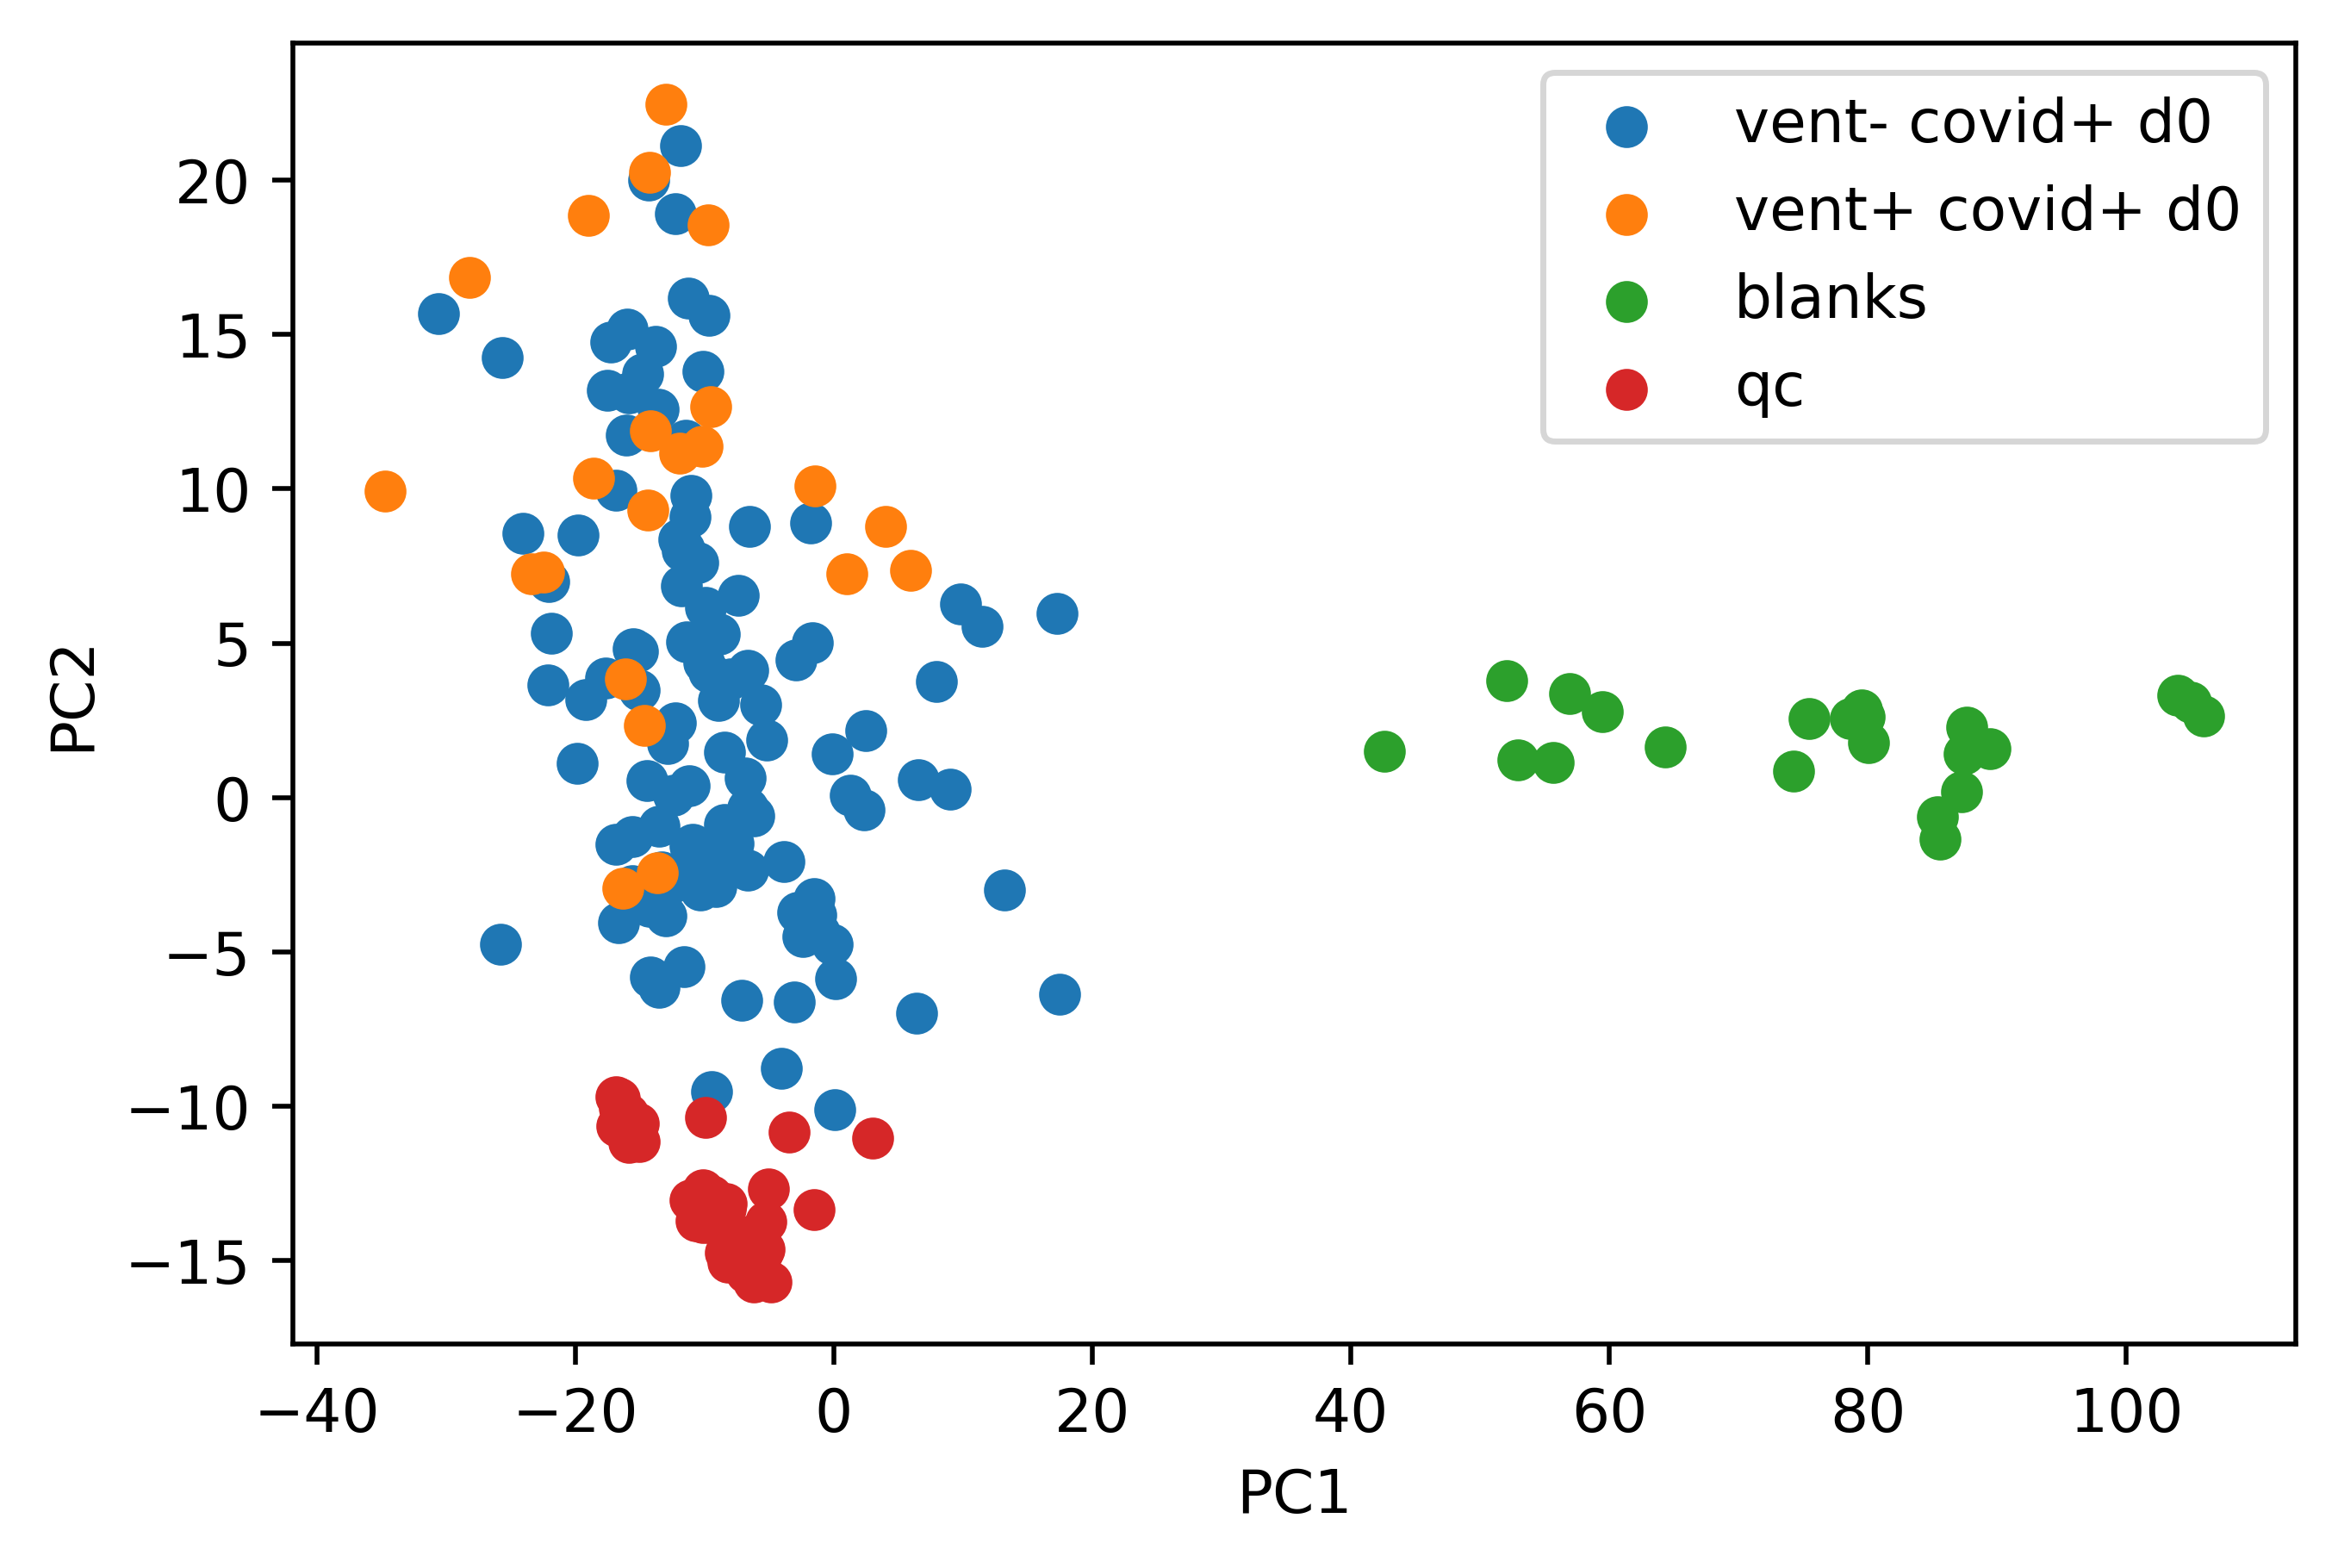

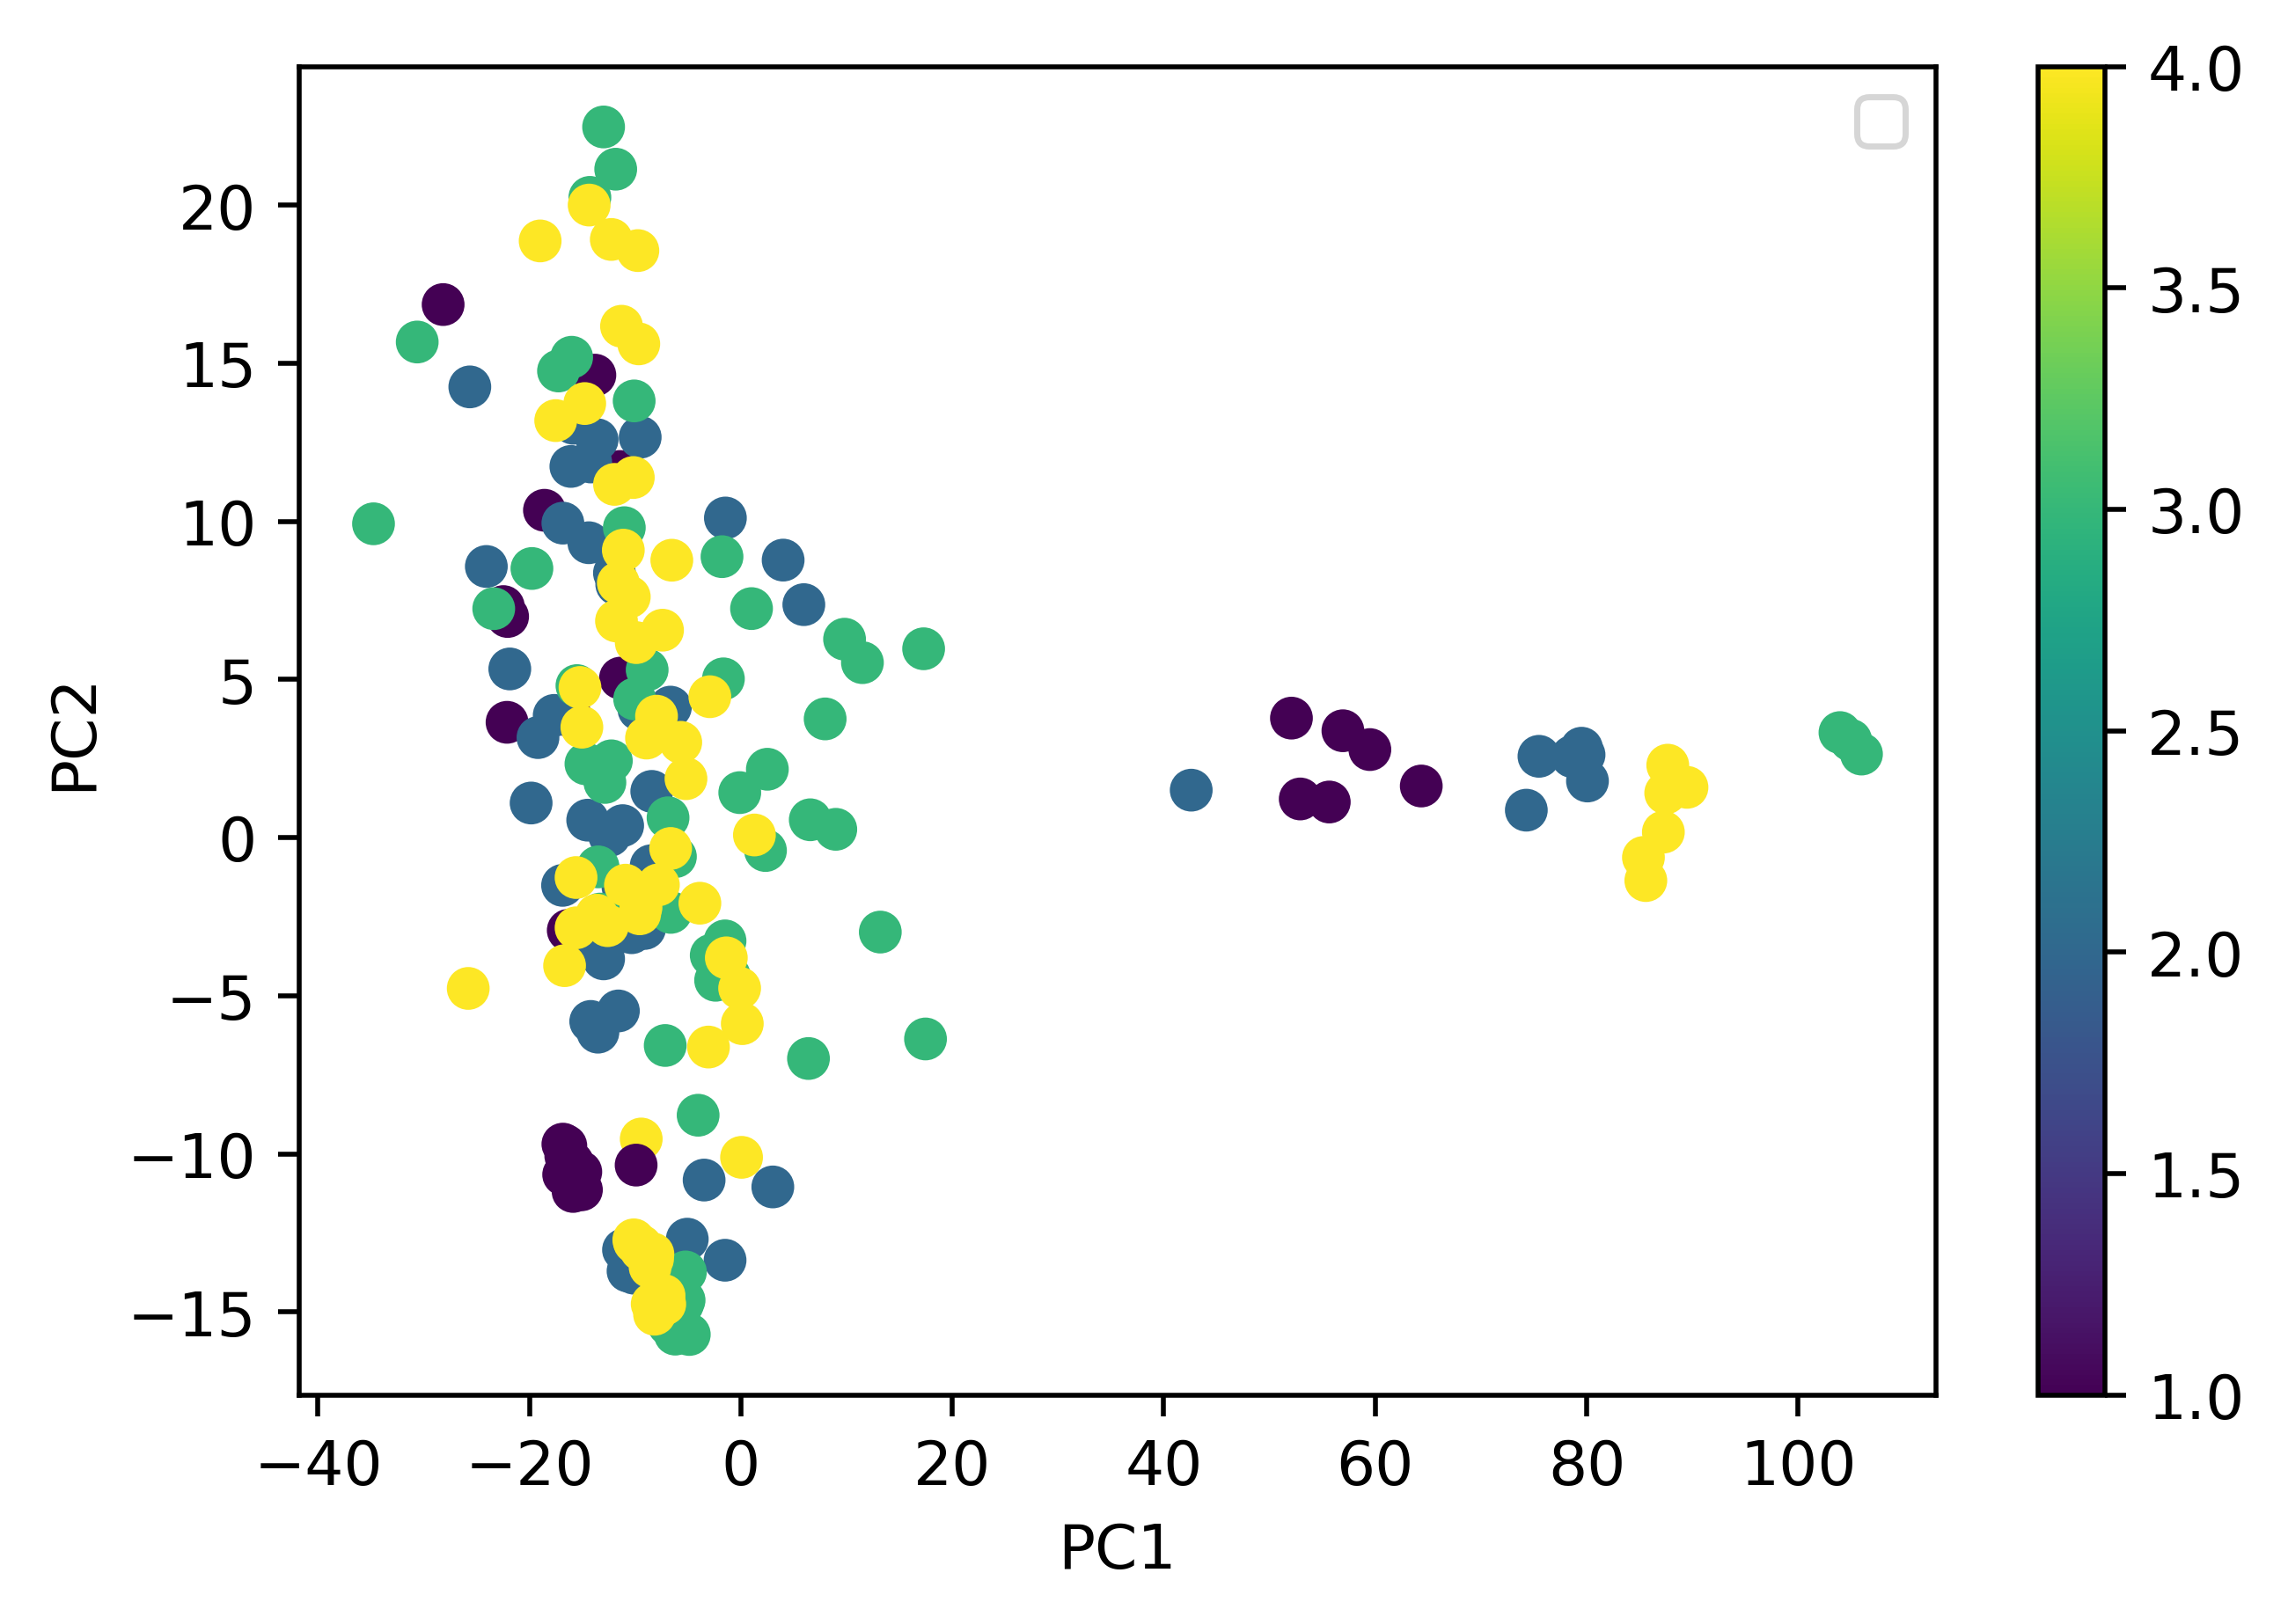

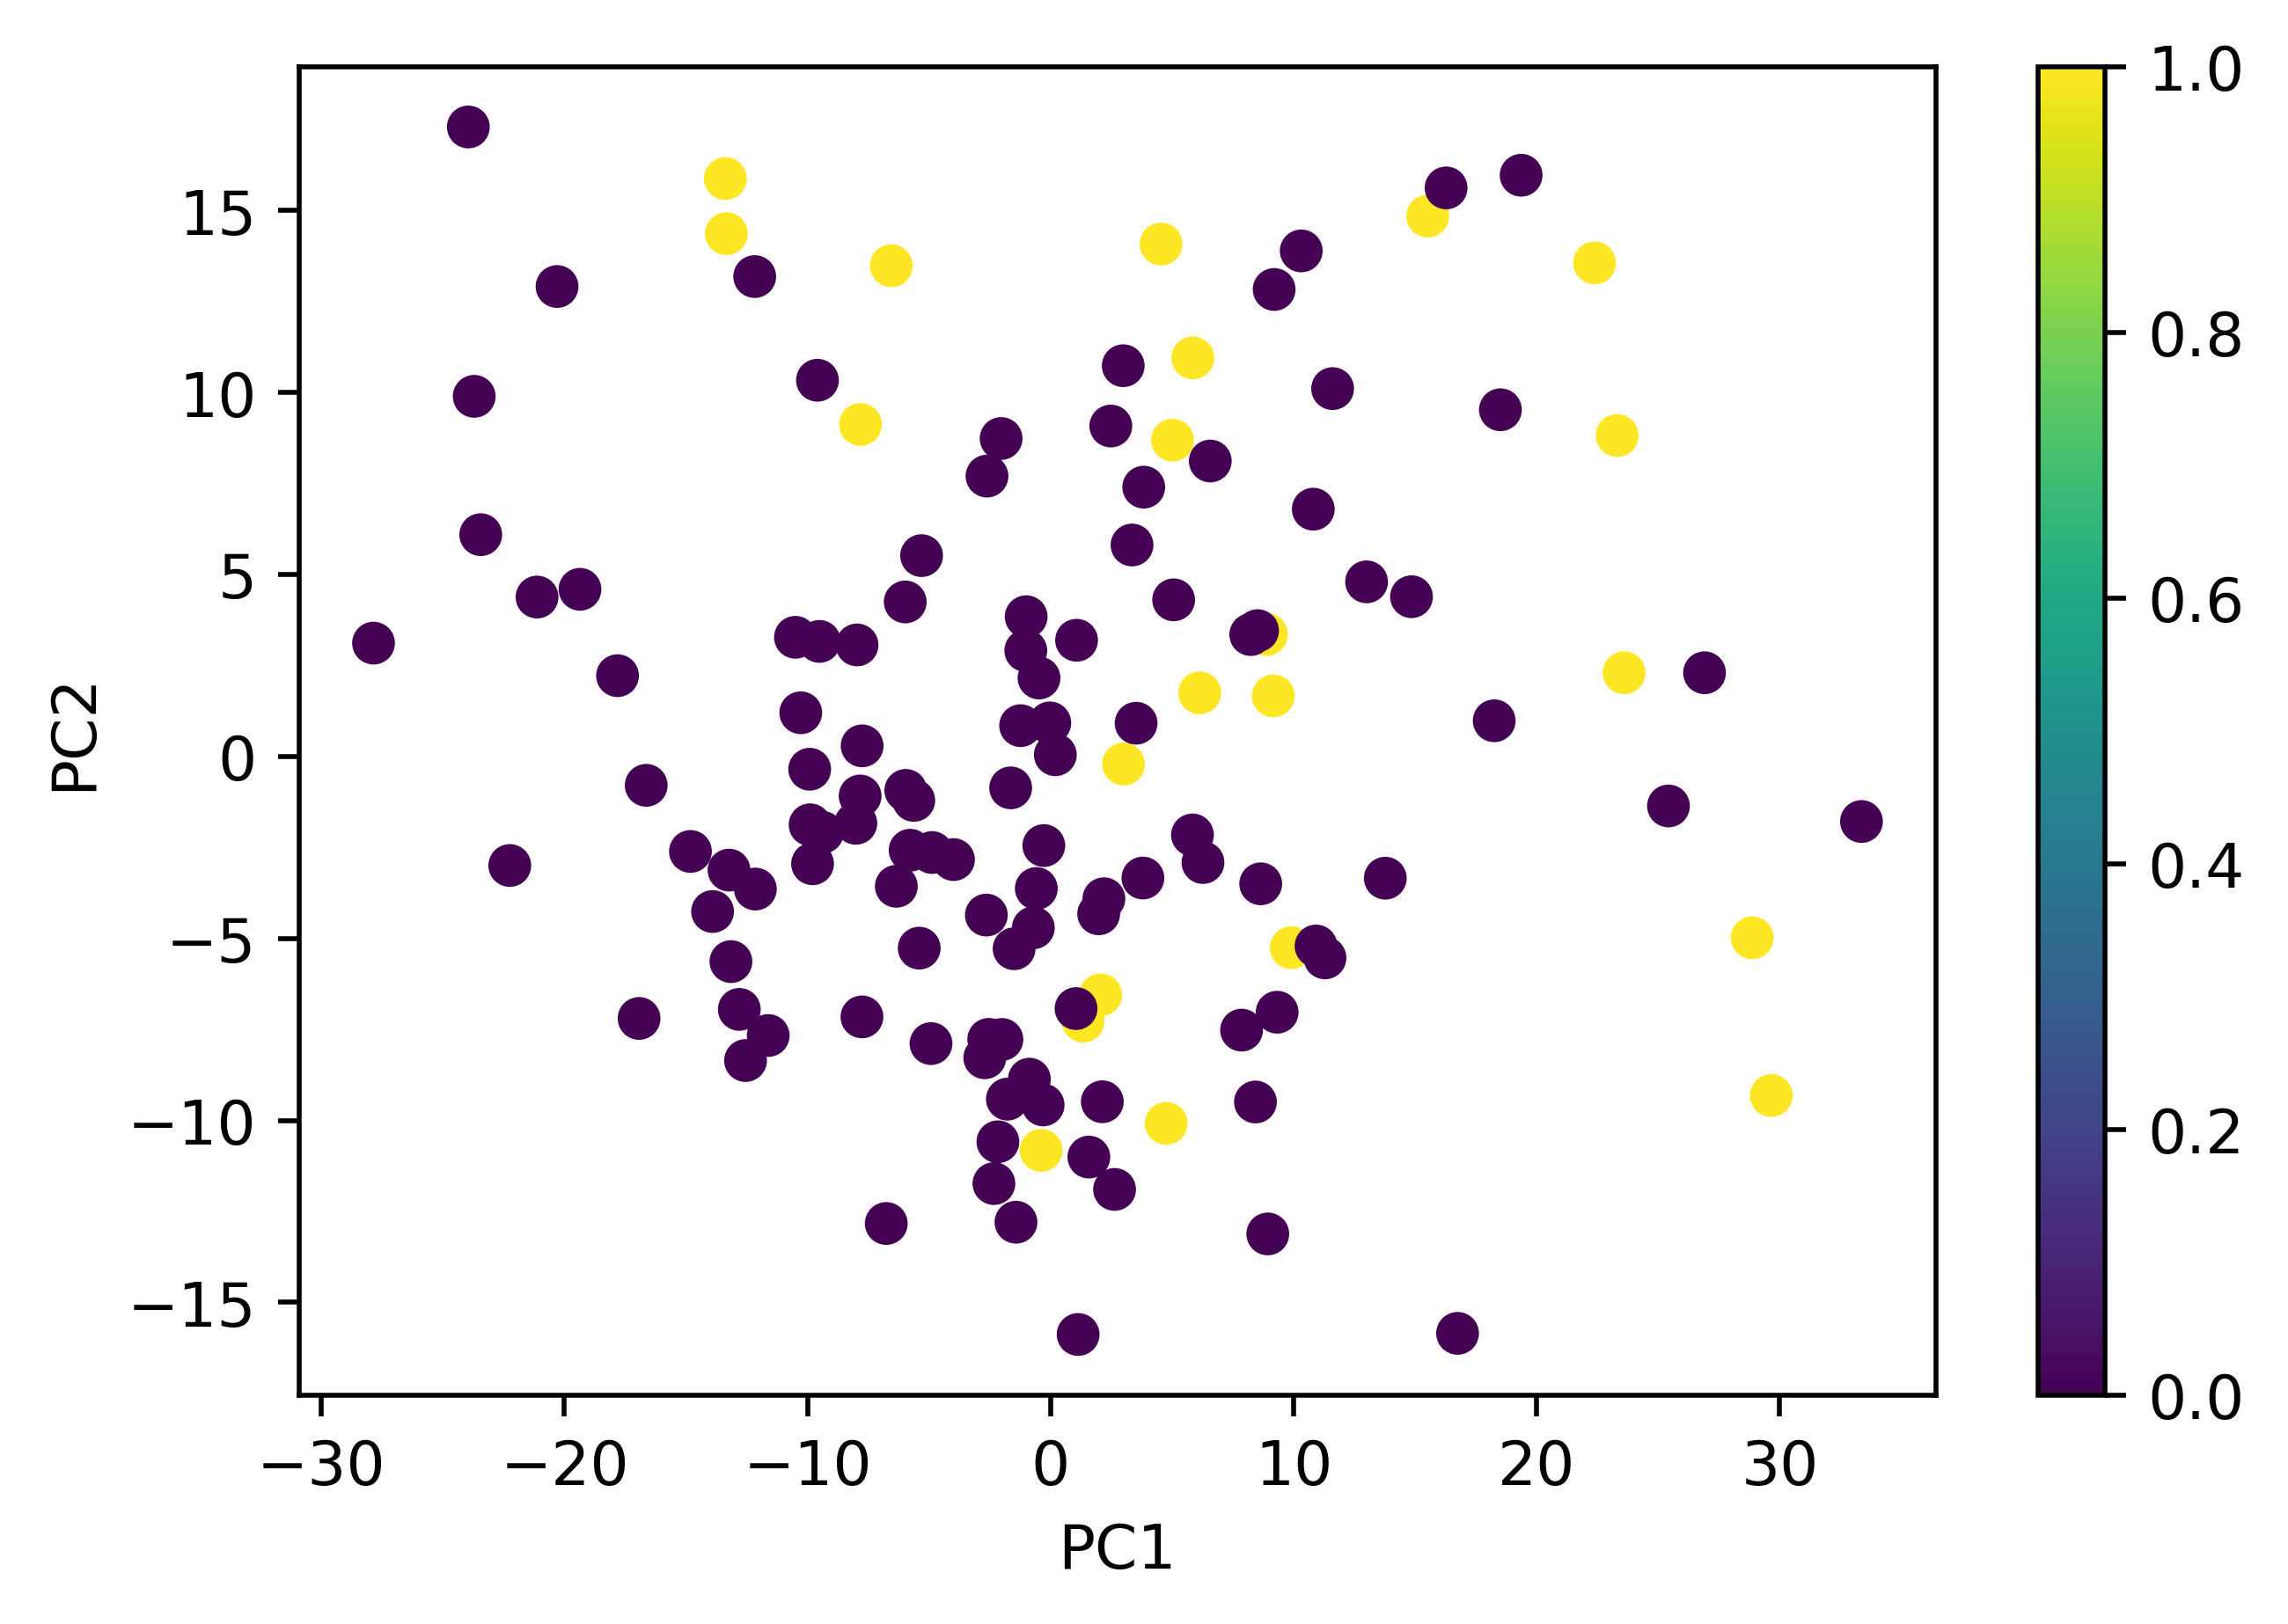

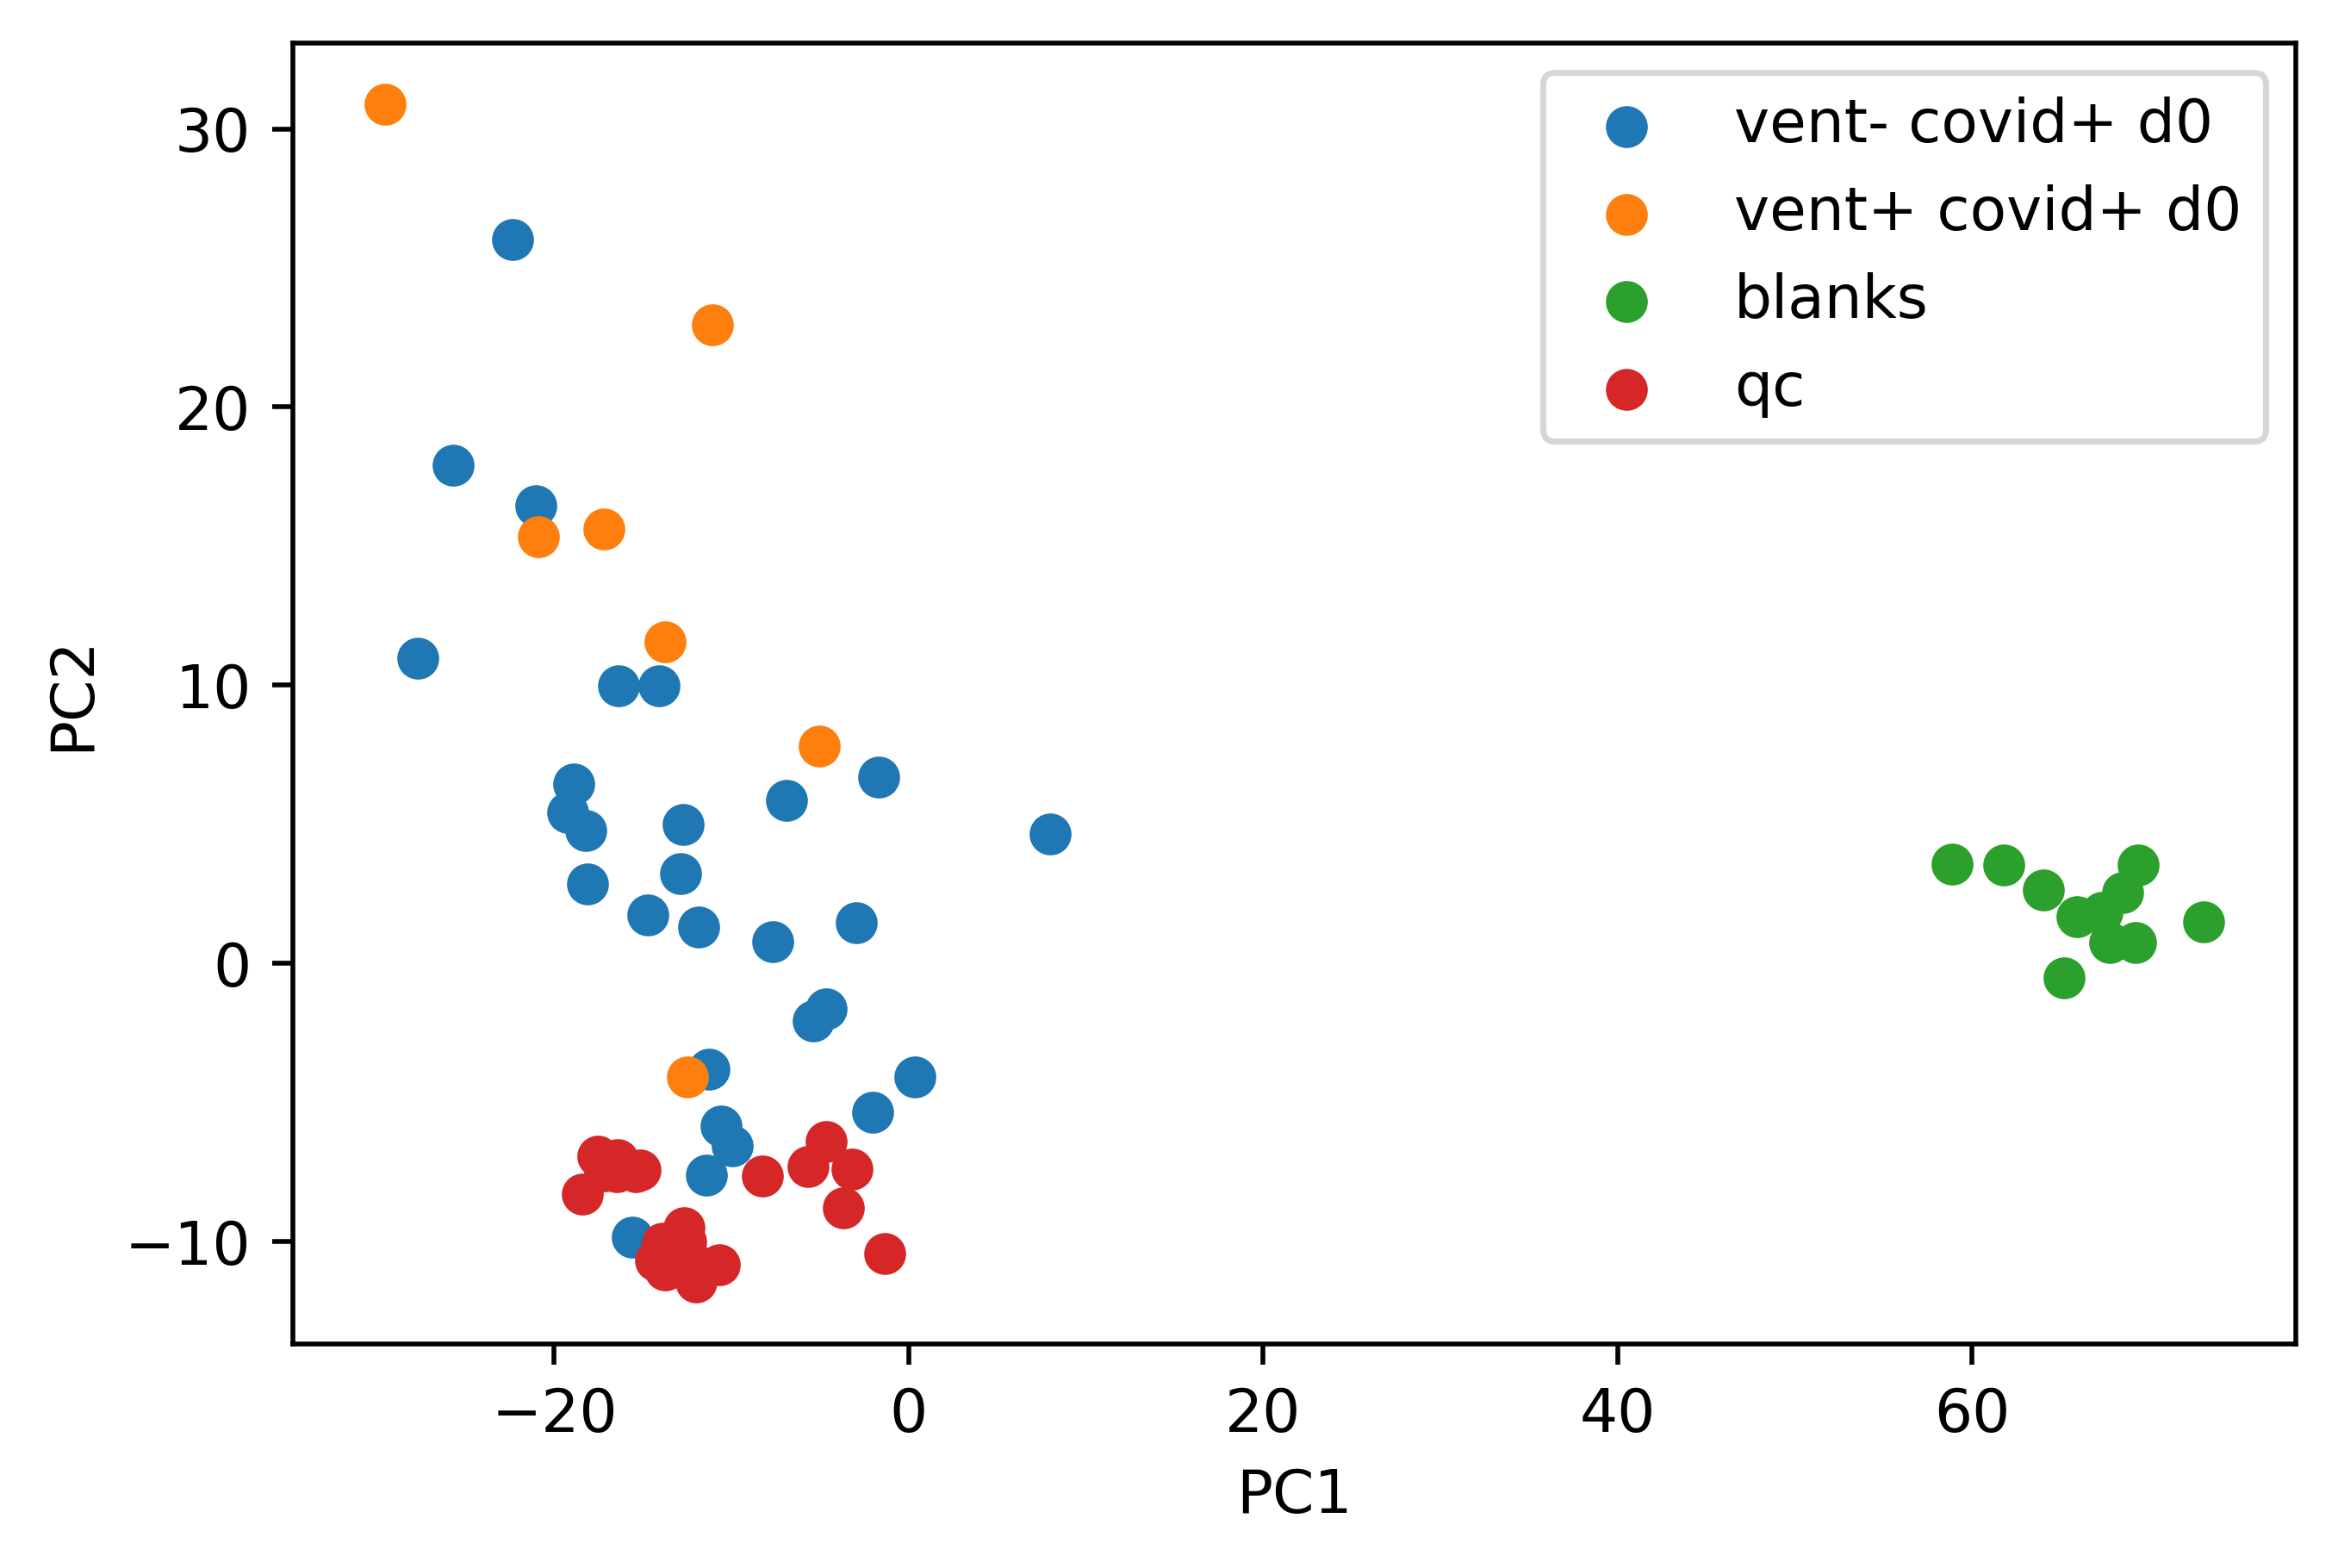

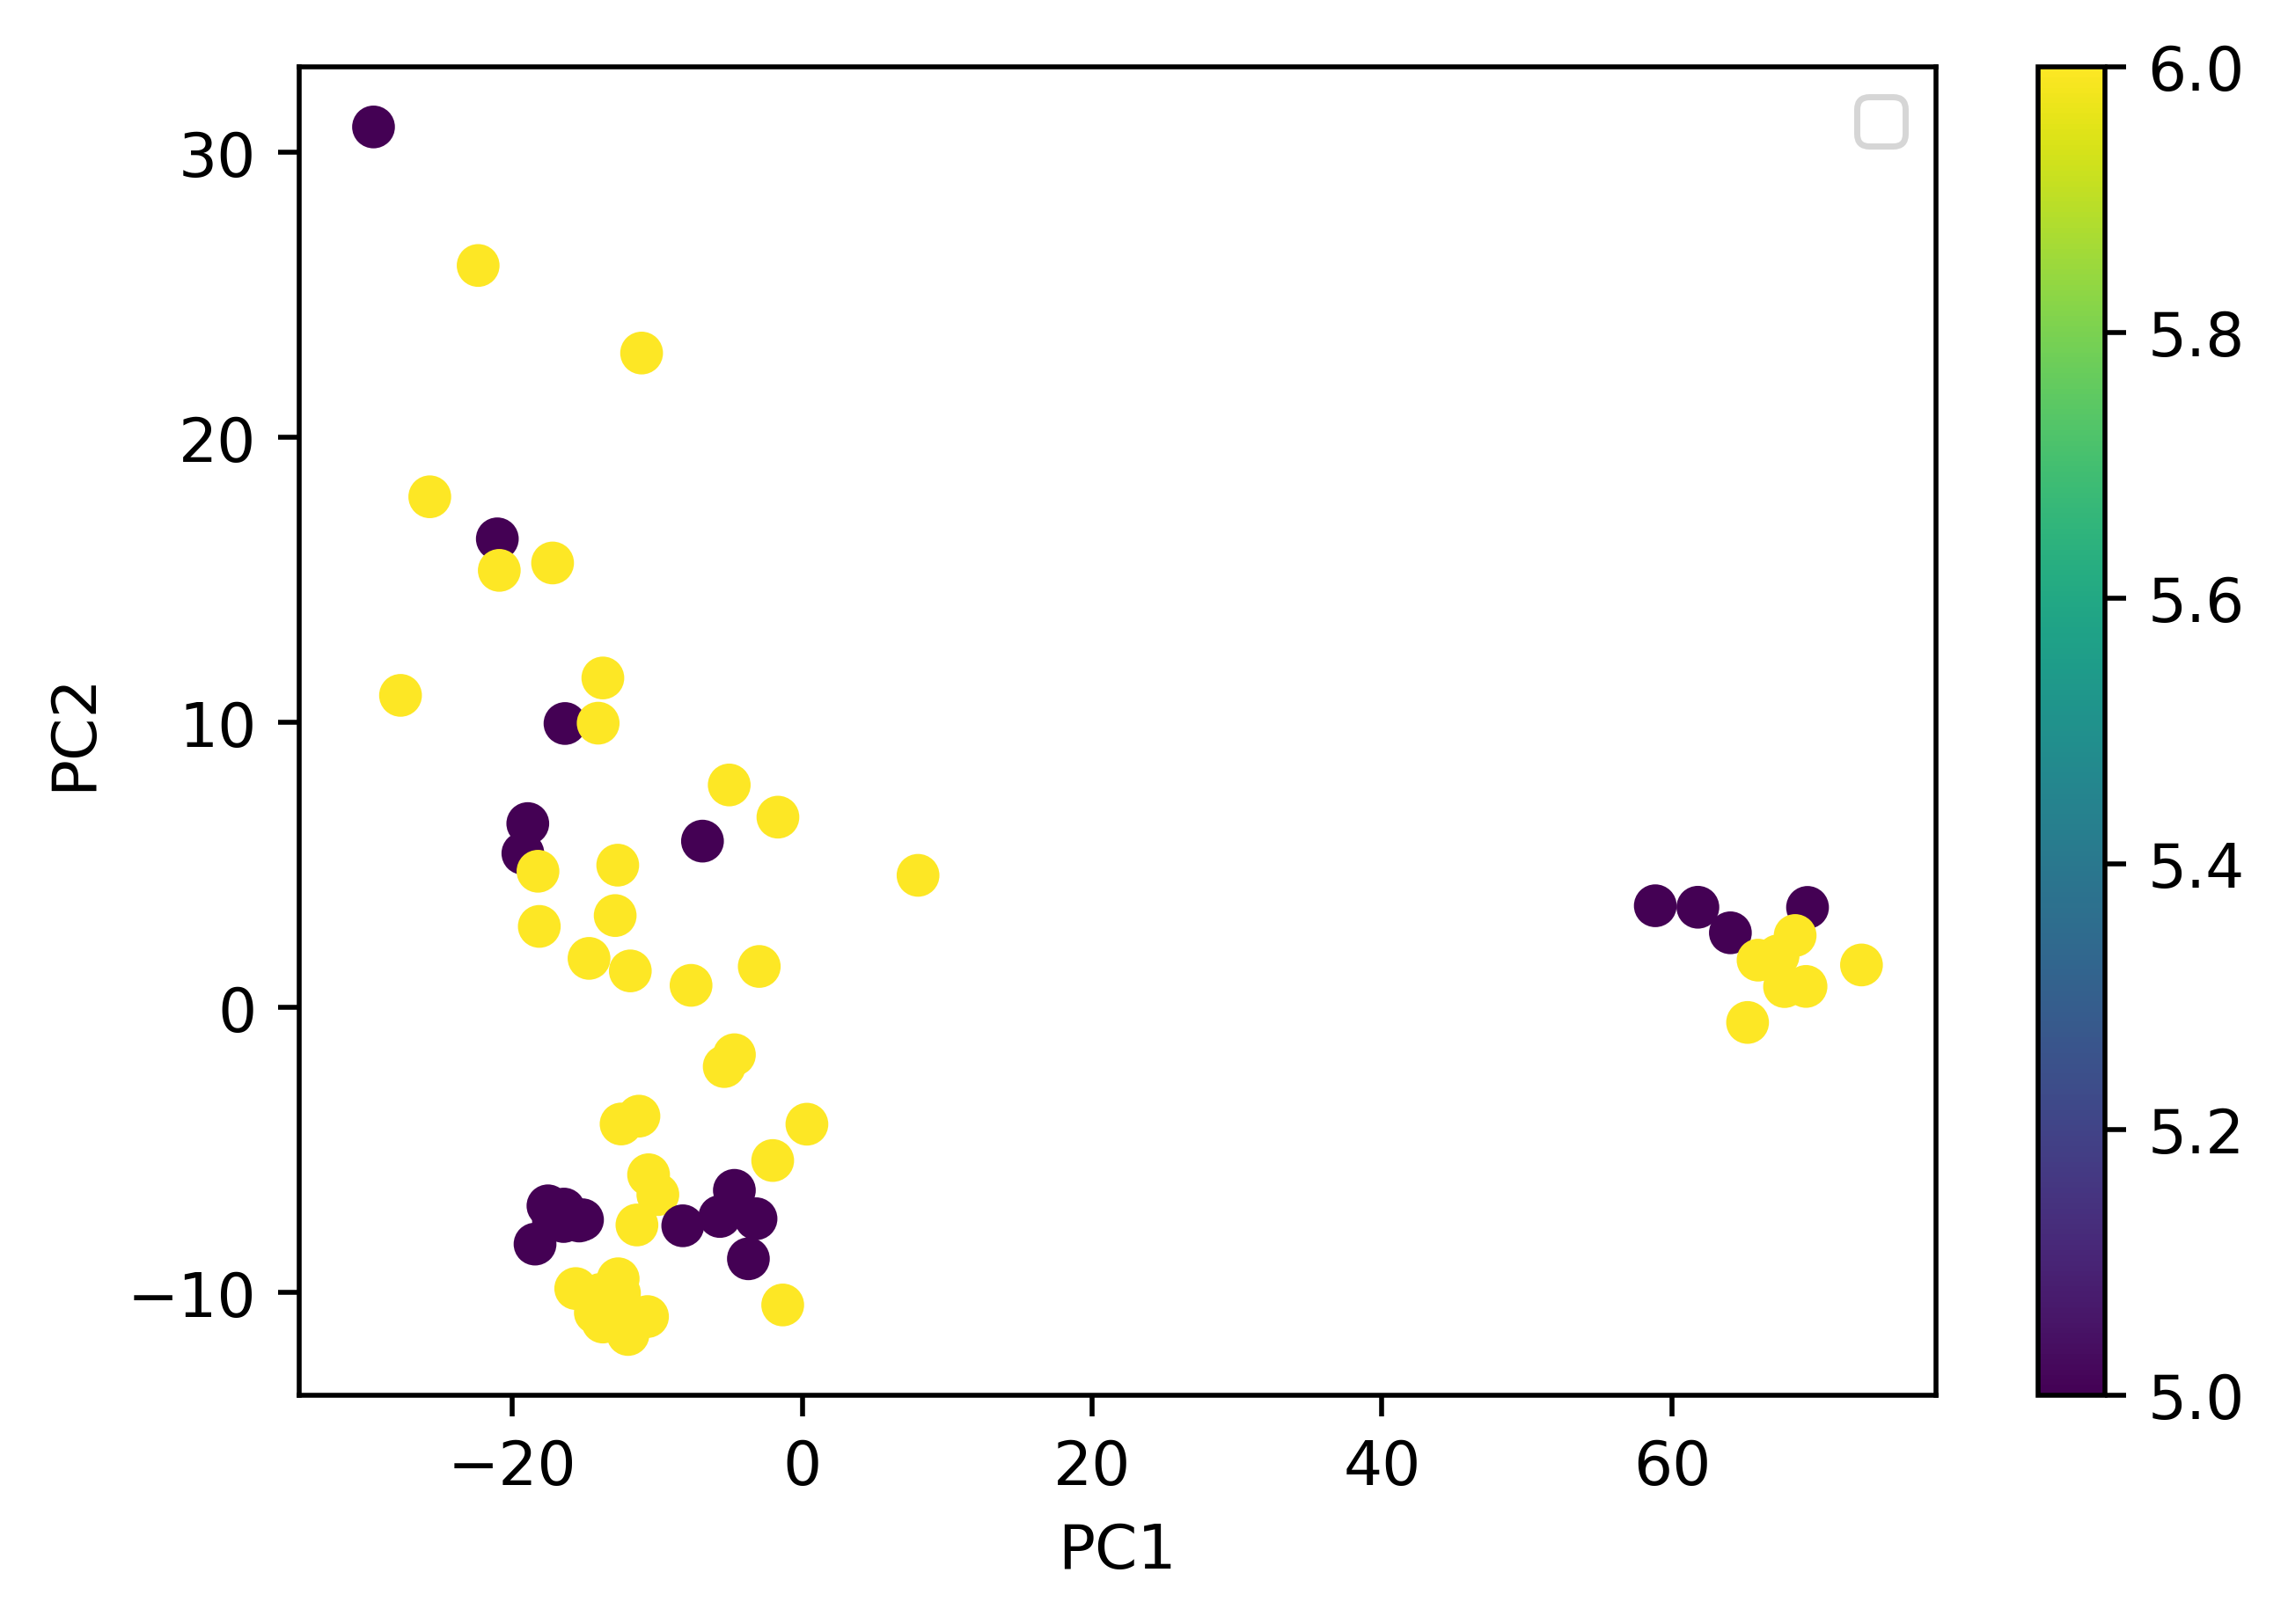

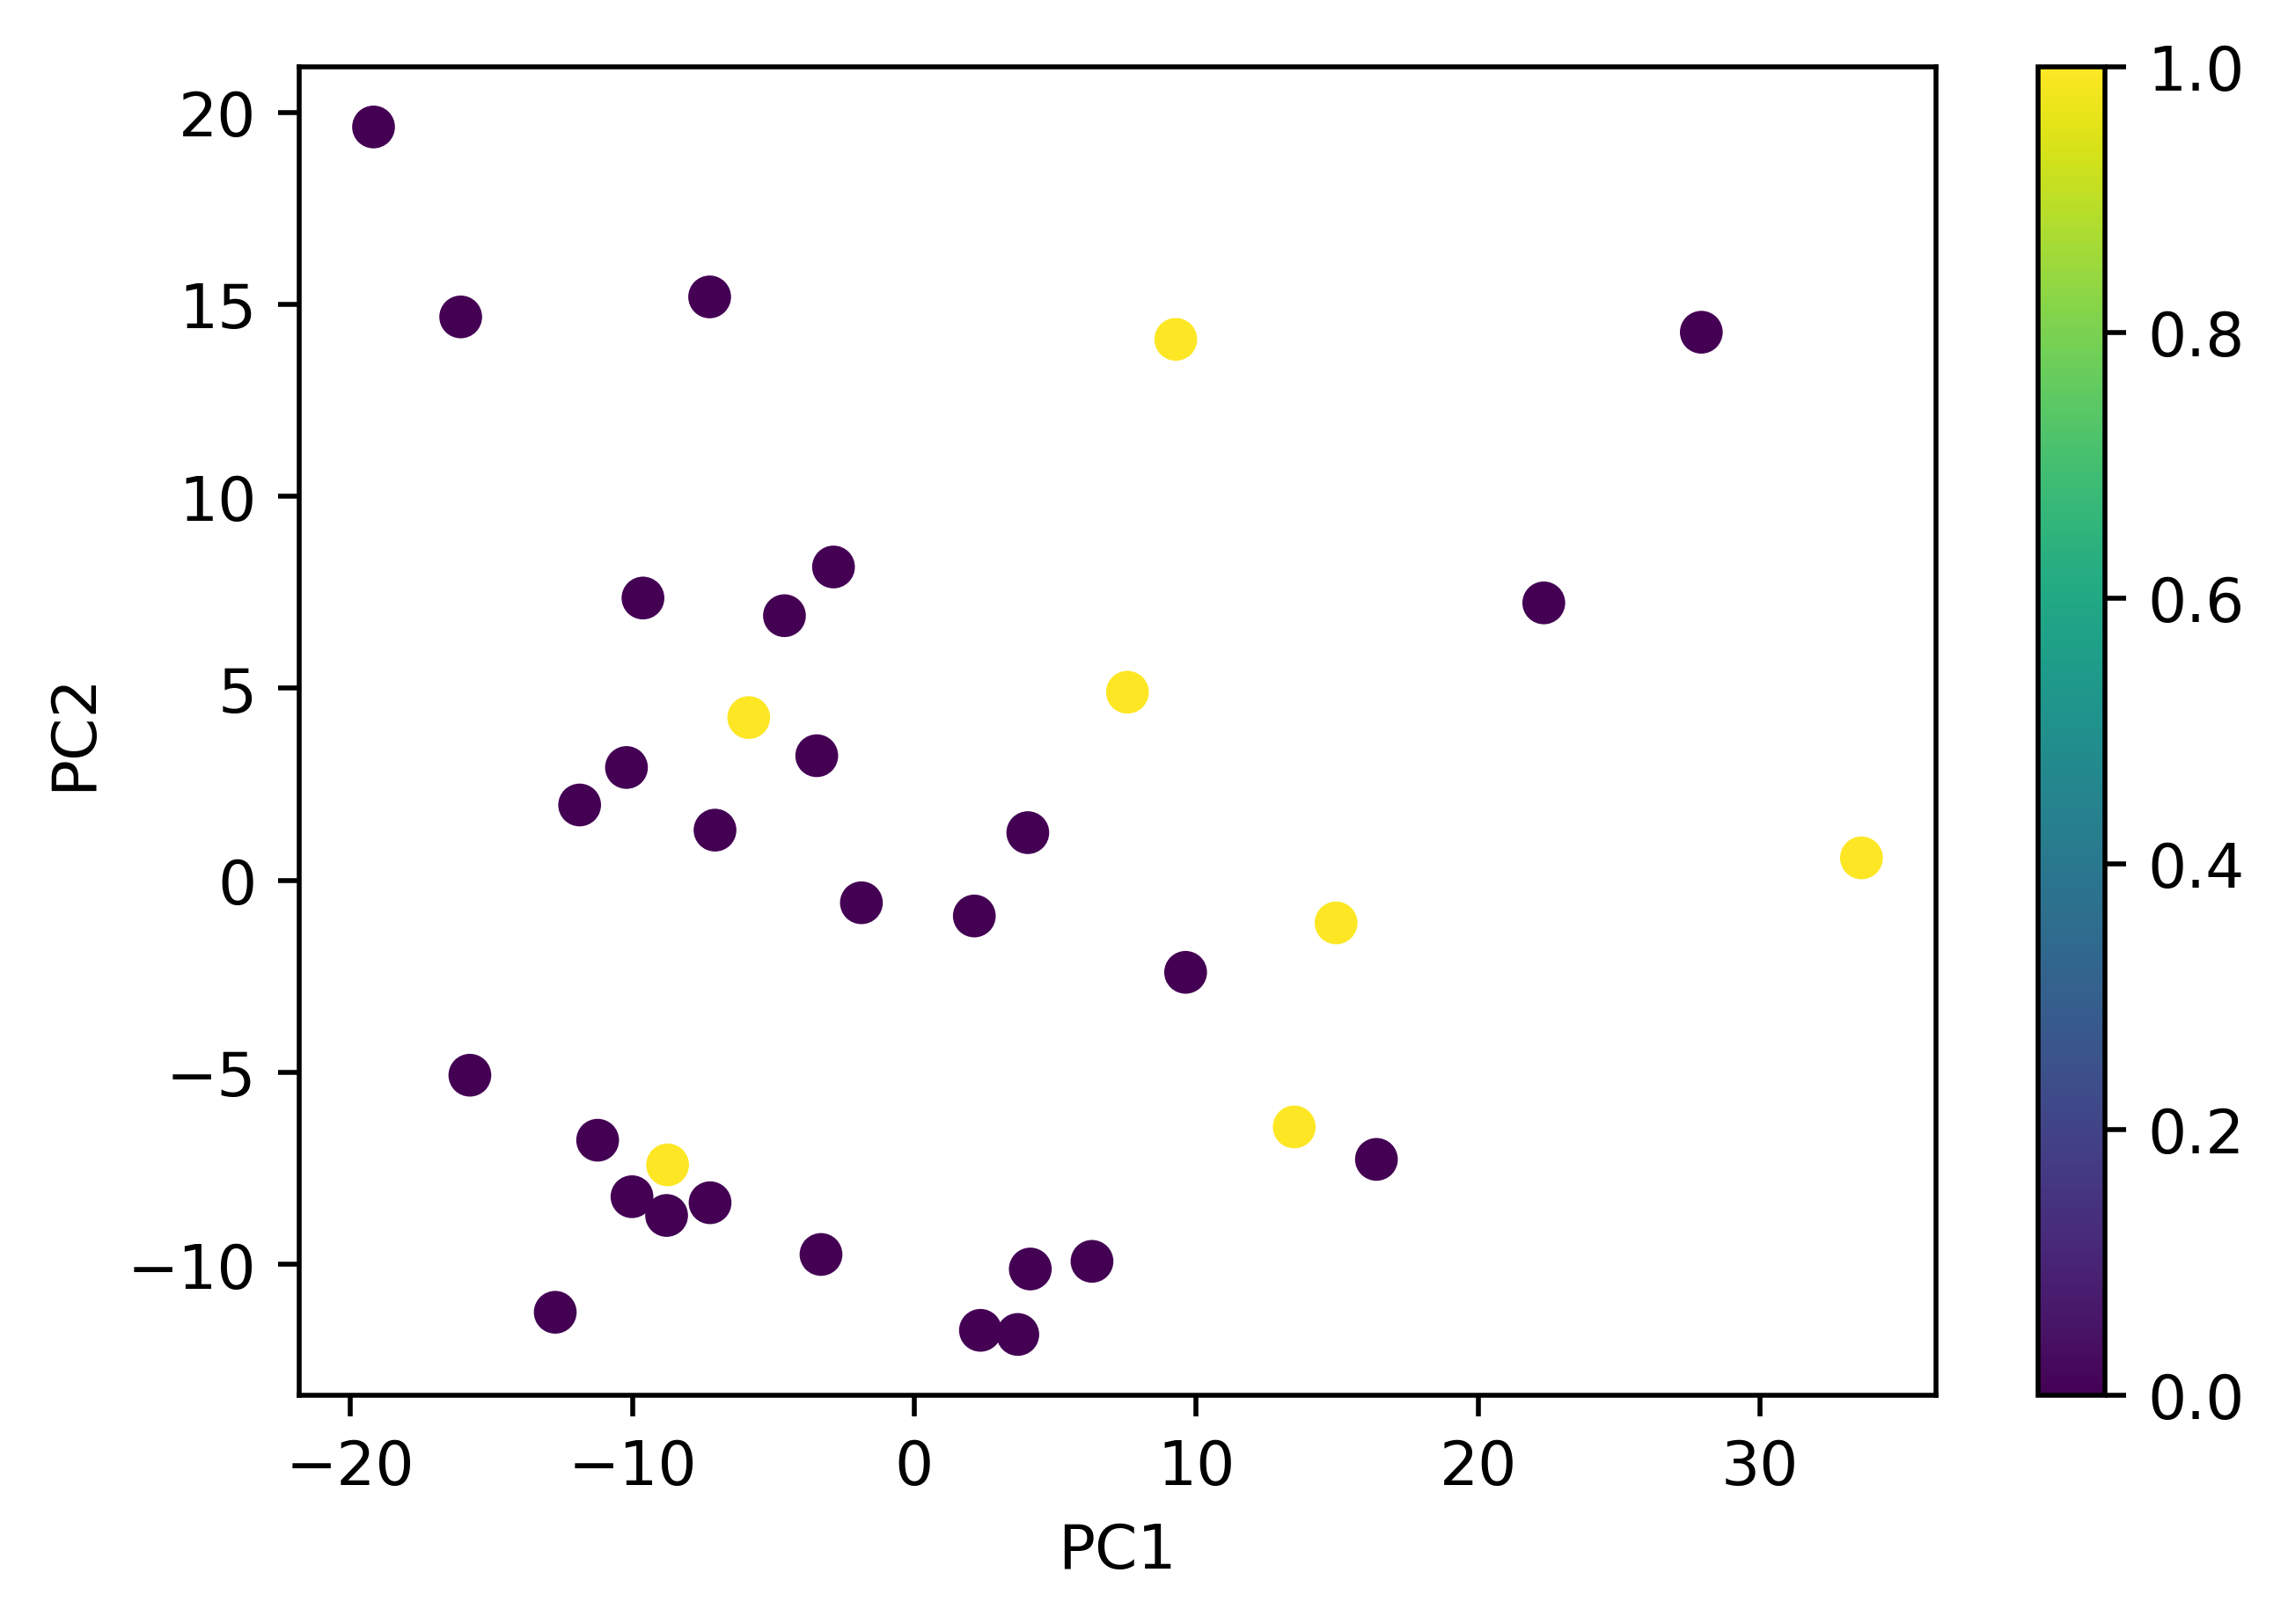

In [8]:
#normalize and imput 

train_whole = np.concatenate((samp_train_int,blank_train_int,qc_train_int))
train_whole_imput = imputeRowMin(train_whole,4)

#log2 
train_whole_imput = np.log2(train_whole_imput)


#normalize and imput testing data

test_whole = np.concatenate((samp_test_int,blank_test_int,qc_test_int))
test_whole_imput = imputeRowMin(test_whole,4)

#log2 
test_whole_imput = np.log2(test_whole_imput)

#normalize
temp = np.concatenate((train_whole_imput,test_whole_imput))
tempBatch = np.concatenate((samp_train_batch,blank_train_batch,qc_train_batch,samp_test_batch,blank_test_batch,qc_test_batch))

tempNorm = combat.combat(pd.DataFrame(temp.transpose()),tempBatch).to_numpy().transpose()
train_whole_norm = tempNorm[:len(train_whole_imput)]

test_whole_norm = tempNorm[len(train_whole_imput):]


# #baseline to qcSamps
baseInt = [np.median(x) for x in train_whole_norm[len(samp_train_int)+len(blank_train_int):].transpose()]
train_whole_norm = np.array([[v-med for v,med in zip(row,baseInt)] for row in train_whole_norm])

# #baseline to qcSamps
baseInt = [np.median(x) for x in test_whole_norm[len(samp_test_int)+len(blank_test_int):].transpose()]
test_whole_norm = np.array([[v-med for v,med in zip(row,baseInt)] for row in test_whole_norm])


#do pca 
pca = PCA(n_components=2)
pca.fit(train_whole_norm)
loads = pca.transform(train_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_train_vent)) if samp_train_vent[x] == 0]
posSamples = [x for x in range(len(samp_train_vent)) if samp_train_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_train_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_train_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_train_int):len(samp_train_int)+len(blank_train_int)]
qc_load = loads[len(samp_train_int)+len(blank_train_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="vent- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="vent+ covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_train_batch,blank_train_batch,qc_train_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate dataset for research samples
X_train = train_whole_norm[:len(samp_train_int)]
y_train = samp_train_vent

X_train_blank = train_whole_norm[len(samp_train_int):len(samp_train_int)+len(blank_train_int)]

#make pca of research samples only
pca = PCA(n_components=2)
pca.fit(X_train)
loads = pca.transform(X_train)

plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=y_train)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

plt.figure()


#do pca 
pca = PCA(n_components=2)
pca.fit(test_whole_norm)
loads = pca.transform(test_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_test_vent)) if samp_test_vent[x] == 0]
posSamples = [x for x in range(len(samp_test_vent)) if samp_test_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_test_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_test_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_test_int):len(samp_test_int)+len(blank_test_int)]
qc_load = loads[len(samp_test_int)+len(blank_test_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="vent- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="vent+ covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_test_batch,blank_test_batch,qc_test_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate dataset for research samples
X_test = test_whole_norm[:len(samp_test_int)]
y_test = samp_test_vent

#make pca of research samples only
pca = PCA(n_components=2)
pca.fit(X_test)
loads = pca.transform(X_test)

plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=y_test)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()


In [9]:
#perform feature selection from training data 


def featureSelection(X_train,y_train,plot=True,out=True,alpha=0.05,fc_cutoff = 2):
    #filter mets in blank

    #compute stats
    pvals = []
    for met in range(len(X_train[0])):
        stat,p = stats.ttest_ind(X_train[:,met],X_train_blank[:,met],equal_var=False)
        pvals.append(p)

    reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
    sigMet_blank = [x for x in range(len(reject)) if reject[x] and
                    np.mean(X_train[:,x])/np.mean(X_train_blank[:,x]) > fc_cutoff]
    if out: print(len(sigMet_blank), "compounds sig. higher in samples than blank")

    #filter mets in vent+/-

    #separate negative and positive examples
    ventNeg = np.array([x for x,y in zip(X_train,y_train) if y < .5])
    ventPos = np.array([x for x,y in zip(X_train,y_train) if y > .5])

    #compute stats
    pvals = []
    for met in range(len(X_train[0])):
        stat,p = stats.ttest_ind(ventNeg[:,met],ventPos[:,met],equal_var=False)
        pvals.append(p)

    reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
    sigMet_vent = [x for x in range(len(reject)) if reject[x]]

    if out: print(len(sigMet_vent), "compounds sig. diff between vent+ and vent-")

    selectedFeatures = list(set(sigMet_vent).intersection(set(sigMet_blank)))
    if out: print(len(selectedFeatures), "compounds sig. diff between vent+ and vent- and sig. higher than blank")


    #plot feature intensity for sig mets
    if plot:
        xpos = 0
        poses = []
        labels = []
        for met in selectedFeatures:
            metName = mol_names[met]
            plt.bar([xpos,xpos+1],[np.mean(ventNeg[:,met]),np.mean(ventPos[:,met])],yerr=[np.std(ventNeg[:,met]),np.std(ventPos[:,met])],color=["red","black"],capsize=3)
            poses.append(xpos+.5)
            labels.append(metName)
            xpos += 3

        plt.plot([-10,-10],[0,1],color="red",label="Vent. Neg")
        plt.plot([-10,-10],[0,1],color="black",label="Vent. Pos")
        plt.xticks(poses,labels=labels,rotation = 90)
        plt.xlim((min(poses)-2,max(poses)+2))
        plt.legend()
        plt.ylabel("normalized intensity")

    return selectedFeatures

In [10]:
#try with logistic regression model
if __name__ ==  '__main__': 

    #iterate over hyperparams
    results = {}
    for fc_cutoff in np.linspace(0,4,5):
        for a in [1e-3,1e-2,0.05,1.0]:
            for c in [0.001,0.01,.1,1,10,100]:
                for el_n in list(np.linspace(0,1,10)) + ["l1","l2","none"]:

                    #make model object

                    if type(el_n) == type(str()):
                        if el_n == "l1":
                            log_pred = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced",penalty=el_n,C=c)
                        else:
                            log_pred = LogisticRegression(fit_intercept=True,class_weight="balanced",penalty=el_n,C=c)
                    else:
                        log_pred = LogisticRegression(fit_intercept=True,class_weight="balanced",solver="saga",
                                                      penalty="elasticnet",l1_ratio=el_n,C=c)

                    #func for cross val training
                    def trainModel(obj,X_train,y_train):
                        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
                        if len(selected_feats) > 0:
                            X_train_sig = X_train[:,selected_feats]
                            obj.fit(X_train_sig,y_train)
                        obj._selectedvars = selected_feats

                    #func for cross val prediction
                    def predictModel(obj,X_test):
                        if len(obj._selectedvars) > 0:
                            return obj.predict(X_test[:,obj._selectedvars])
                        else:
                            return np.array([1 for _ in X_test])

                    #cross validate
                    r2,y_pred,y_true = crossVal(X_train,y_train,log_pred,trainModel,predictModel,k=len(X_train))

                    err_cv = sklearn.metrics.f1_score(y_true,y_pred)

                    #output error
                    results[(fc_cutoff,a,el_n,c)] = err_cv

    bestParams = [key for key in results if abs(results[key] - max(list(results.values()))) < 1e-4][0]
    print(bestParams)

    fc_cutoff,a,el_n,c = bestParams

    selected_feats = featureSelection(X_train,y_train,True,True,alpha=a,fc_cutoff=fc_cutoff)

    #if some features selected
    if len(selected_feats) > 0:

        #parse selected features
        X_train_sig = X_train[:,selected_feats]

        #fit model
        if type(el_n) == type(str()):
            if el_n == "l1":
                log_pred = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced",penalty=el_n,C=c)
            else:
                log_pred = LogisticRegression(fit_intercept=True,class_weight="balanced",penalty=el_n,C=c)
        else:
            log_pred = LogisticRegression(fit_intercept=True,class_weight="balanced",solver="saga",penalty="elasticnet",
                                          l1_ratio=el_n,C=c)

        log_pred.fit(X_train_sig,y_train)

        #predict
        y_pred = log_pred.predict(X_train_sig) 
    else:
        y_pred = np.array([1 for _ in y_train])

    #assess training error
    err_train = sklearn.metrics.f1_score(y_train,y_pred)
    print("training error: ",err_train)

    print(sklearn.metrics.confusion_matrix(y_train,y_pred))

    #func for cross val training
    def trainModel(obj,X_train,y_train):
        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
        if len(selected_feats) > 0:
            X_train_sig = X_train[:,selected_feats]
            obj.fit(X_train_sig,y_train)
        obj._selectedvars = selected_feats

    #func for cross val prediction
    def predictModel(obj,X_test):
        if len(obj._selectedvars) > 0:
            return obj.predict(X_test[:,obj._selectedvars])
        else:
            return np.array([1 for _ in X_test])

    #cross validate
    r2,y_pred,y_true = crossVal(X_train,y_train,log_pred,trainModel,predictModel,k=len(X_train))

    err_cv = sklearn.metrics.f1_score(y_true,y_pred)
    print("cv_error: ",err_cv)
    print(sklearn.metrics.confusion_matrix(y_true,y_pred))



KeyboardInterrupt: 

In [ ]:
if __name__ ==  '__main__': 
    #try with elastic net

    #iterate over hyperparams
    results = {}
    for eln in np.linspace(0,1,10):
        for fc_cutoff in np.linspace(0,4,5):
            for a in [1e-3,1e-2,0.05,1.0]:
                for lam in [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]:

                    #make model object
                    lasso = ElasticNet(fit_intercept=True,alpha=lam,l1_ratio=eln)

                    #func for cross val training
                    def trainModel(obj,X_train,y_train):
                        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
                        sampleWeights = sklearn.utils.class_weight.compute_sample_weight("balanced",y_train)

                        if len(selected_feats) > 0:
                            X_train_sig = X_train[:,selected_feats]
                            obj.fit(X_train_sig,y_train,sample_weight = sampleWeights)
                            classi = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced")
                            classi.fit([[x] for x in obj.predict(X_train_sig)],y_train)
                            obj._classi = classi

                        obj._selectedvars = selected_feats

                    #func for cross val prediction
                    def predictModel(obj,X_test):
                        if len(obj._selectedvars) > 0:
                            return obj._classi.predict([[x] for x in obj.predict(X_test[:,obj._selectedvars])])
                        else:
                            return np.array([1 for _ in X_test])

                    #cross validate
                    r2,y_pred,y_true = crossVal(X_train,y_train,lasso,trainModel,predictModel,,k=len(X_train))

                    err_cv = sklearn.metrics.f1_score(y_true,y_pred)

                    #output error
                    results[(fc_cutoff,a,el_n,lam)] = err_cv

    bestParams = [key for key in results if abs(results[key] - max(list(results.values()))) < 1e-4][0]
    print(bestParams)

    fc_cutoff,a,el_n,lam = bestParams

    selected_feats = featureSelection(X_train,y_train,True,True,alpha=a,fc_cutoff=fc_cutoff)

    #if some features selected
    if len(selected_feats) > 0:

        #parse selected features
        X_train_sig = X_train[:,selected_feats]

        #fit model
        lasso = ElasticNet(fit_intercept=True,alpha=lam,l1_ratio=eln)
        sampleWeights = sklearn.utils.class_weight.compute_sample_weight("balanced",y_train)
        print(type(y_train),type(X_train_sig))
        lasso.fit(X_train_sig,y_train,sample_weight = sampleWeights)
        classi = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced")
        classi.fit([[x] for x in lasso.predict(X_train_sig)],y_train)
        #predict
        y_pred = classi.predict([[x] for x in lasso.predict(X_train_sig)])
    else:
        y_pred = np.array([1 for _ in y_train])

    #assess training error
    err_train = sklearn.metrics.f1_score(y_train,y_pred)
    print("training error: ",err_train)

    print(sklearn.metrics.confusion_matrix(y_train,y_pred))

    #func for cross val training
    def trainModel(obj,X_train,y_train):
        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
        sampleWeights = sklearn.utils.class_weight.compute_sample_weight("balanced",y_train)

        if len(selected_feats) > 0:
            X_train_sig = X_train[:,selected_feats]
            obj.fit(X_train_sig,y_train,sample_weight = sampleWeights)
            classi = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced")
            classi.fit([[x] for x in obj.predict(X_train_sig)],y_train)
            obj._classi = classi

        obj._selectedvars = selected_feats

    #func for cross val prediction
    def predictModel(obj,X_test):
        if len(obj._selectedvars) > 0:
            return obj._classi.predict([[x] for x in obj.predict(X_test[:,obj._selectedvars])])
        else:
            return np.array([1 for _ in X_test])

    #cross validate
    r2,y_pred,y_true = crossVal(X_train,y_train,lasso,trainModel,predictModel,k=len(X_train))

    err_cv = sklearn.metrics.f1_score(y_true,y_pred)
    print("cv_error: ",err_cv)
    print(sklearn.metrics.confusion_matrix(y_true,y_pred))

In [ ]:
if __name__ ==  '__main__': 
    #try with plsda

    #iterate over hyperparams
    results = {}
    for num_c in range(1,5):
        for fc_cutoff in np.linspace(0,4,5):
            for a in [1e-3,1e-2,0.05,1.0]:
                #make model object
                pls = PLSRegression(num_c)

                #func for cross val training
                def trainModel(obj,X_train,y_train):
                    selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
                    sampleWeights = sklearn.utils.class_weight.compute_sample_weight("balanced",y_train)

                    if len(selected_feats) > 0:
                        if len(selected_feats) < num_c:
                            pls.n_components = len(selected_feats)
                        X_train_sig = X_train[:,selected_feats]
                        obj.fit(X_train_sig,y_train)
#                         classi = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced")
#                         classi.fit([[x] for x in obj.predict(X_train_sig)[:,0]],y_train)
#                         obj._classi = classi

                    obj._selectedvars = selected_feats

                #func for cross val prediction
                def predictModel(obj,X_test):
                    if len(obj._selectedvars) > 0:
                        return sklearn.preprocessing.binarize(obj.predict(X_test[:,obj._selectedvars]),.5)[:,0]
                    else:
                        return np.array([1 for _ in X_test])

                #cross validate
                r2,y_pred,y_true = crossVal(X_train,y_train,pls,trainModel,predictModel,k=len(X_train))

                err_cv = sklearn.metrics.f1_score(y_true,y_pred)

                #output error
                results[num_c,fc_cutoff,a] = err_cv

    bestParams = [key for key in results if abs(results[key] - max(list(results.values()))) < 1e-4][0]
    print(bestParams)

    num_c,fc_cutoff,a = bestParams

    selected_feats = featureSelection(X_train,y_train,True,True,alpha=a,fc_cutoff=fc_cutoff)

    #if some features selected
    if len(selected_feats) > 0:

        #parse selected features
        X_train_sig = X_train[:,selected_feats]

        #fit model
        pls = PLSRegression(num_c)
        sampleWeights = sklearn.utils.class_weight.compute_sample_weight("balanced",y_train)

        pls.fit(X_train_sig,y_train)
        classi = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced")
        classi.fit([[x] for x in pls.predict(X_train_sig)[:,0]],y_train)
        #predict
        y_pred = classi.predict([[x] for x in pls.predict(X_train_sig)[:,0]])
    else:
        y_pred = np.array([1 for _ in y_train])

    #assess training error
    err_train = sklearn.metrics.f1_score(y_train,y_pred)
    print("training error: ",err_train)

    print(sklearn.metrics.confusion_matrix(y_train,y_pred))

    #func for cross val training
    def trainModel(obj,X_train,y_train):
        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
        sampleWeights = sklearn.utils.class_weight.compute_sample_weight("balanced",y_train)

        if len(selected_feats) > 0:
            if len(selected_feats) < num_c:
                pls.n_components = len(selected_feats)
            X_train_sig = X_train[:,selected_feats]
            obj.fit(X_train_sig,y_train)
#                         classi = LogisticRegression(fit_intercept=True,solver="saga",class_weight="balanced")
#                         classi.fit([[x] for x in obj.predict(X_train_sig)[:,0]],y_train)
#                         obj._classi = classi

        obj._selectedvars = selected_feats

    #func for cross val prediction
    def predictModel(obj,X_test):
        if len(obj._selectedvars) > 0:
            return sklearn.preprocessing.binarize(obj.predict(X_test[:,obj._selectedvars]),.5)[:,0]
        else:
            return np.array([1 for _ in X_test])

    #cross validate
    r2,y_pred,y_true = crossVal(X_train,y_train,pls,trainModel,predictModel,k=len(X_train))

    err_cv = sklearn.metrics.f1_score(y_true,y_pred)
    print("cv_error: ",err_cv)
    print(sklearn.metrics.confusion_matrix(y_true,y_pred))

In [ ]:
#try with SVM
if __name__ ==  '__main__': 

    #iterate over hyperparams
    results = {}
    for fc_cutoff in np.linspace(0,4,5):
        for a in [1e-3,1e-2,0.05,1.0]:
            for c in [1e-3,1e-2,1e-1,1,10,100]:
                for k in ["linear","poly","rbf","sigmoid"]:
                    

                    #make model object

                    svm = SVC(class_weight="balanced",C=c,kernel=k)

                    #func for cross val training
                    def trainModel(obj,X_train,y_train):
                        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
                        if len(selected_feats) > 0:
                            X_train_sig = X_train[:,selected_feats]
                            obj.fit(X_train_sig,y_train)
                        obj._selectedvars = selected_feats

                    #func for cross val prediction
                    def predictModel(obj,X_test):
                        if len(obj._selectedvars) > 0:
                            return obj.predict(X_test[:,obj._selectedvars])
                        else:
                            return np.array([1 for _ in X_test])

                    #cross validate
                    r2,y_pred,y_true = crossVal(X_train,y_train,svm,trainModel,predictModel,k=10)

                    err_cv = sklearn.metrics.f1_score(y_true,y_pred)

                    #output error
                    results[(fc_cutoff,a,c,k)] = err_cv

    bestParams = [key for key in results if abs(results[key] - max(list(results.values()))) < 1e-4][0]
    print(bestParams)

    fc_cutoff,a,c,k = bestParams

    selected_feats = featureSelection(X_train,y_train,True,True,alpha=a,fc_cutoff=fc_cutoff)

    #if some features selected
    if len(selected_feats) > 0:

        #parse selected features
        X_train_sig = X_train[:,selected_feats]

        #fit model
        svm = SVC(class_weight="balanced",C=c,kernel=k)

        svm.fit(X_train_sig,y_train)

        #predict
        y_pred = svm.predict(X_train_sig) 
    else:
        y_pred = np.array([1 for _ in y_train])

    #assess training error
    err_train = sklearn.metrics.f1_score(y_train,y_pred)
    print("training error: ",err_train)

    print(sklearn.metrics.confusion_matrix(y_train,y_pred))

    #func for cross val training
    def trainModel(obj,X_train,y_train):
        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
        if len(selected_feats) > 0:
            X_train_sig = X_train[:,selected_feats]
            obj.fit(X_train_sig,y_train)
        obj._selectedvars = selected_feats

    #func for cross val prediction
    def predictModel(obj,X_test):
        if len(obj._selectedvars) > 0:
            return obj.predict(X_test[:,obj._selectedvars])
        else:
            return np.array([1 for _ in X_test])

    #cross validate
    r2,y_pred,y_true = crossVal(X_train,y_train,svm,trainModel,predictModel,k=len(X_train))

    err_cv = sklearn.metrics.f1_score(y_true,y_pred)
    print("cv_error: ",err_cv)
    print(sklearn.metrics.confusion_matrix(y_true,y_pred))



In [ ]:
#try with random forest
if __name__ ==  '__main__': 

    #iterate over hyperparams
    results = {}
    for fc_cutoff in np.linspace(0,4,5):
        for a in [1e-3,1e-2,0.05,1.0]:
            for mf in ["auto","log2",None]:
                for md in [None,1,5,10,20,50]:
                    for n_est in np.linspace(1,200,5):
                    
                        n_est = int(n_est)
                        #make model object

                        rf = RandomForestClassifier(n_estimators = n_est,max_depth = md,max_features=mf,n_jobs=-1)

                        #func for cross val training
                        def trainModel(obj,X_train,y_train):
                            selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
                            if len(selected_feats) > 0:
                                X_train_sig = X_train[:,selected_feats]
                                obj.fit(X_train_sig,y_train)
                            obj._selectedvars = selected_feats

                        #func for cross val prediction
                        def predictModel(obj,X_test):
                            if len(obj._selectedvars) > 0:
                                return obj.predict(X_test[:,obj._selectedvars])
                            else:
                                return np.array([1 for _ in X_test])

                        #cross validate
                        r2,y_pred,y_true = crossVal(X_train,y_train,rf,trainModel,predictModel,k=len(X_train))

                        err_cv = sklearn.metrics.f1_score(y_true,y_pred)

                        #output error
                        results[(fc_cutoff,a,mf,md,n_est)] = err_cv

    bestParams = [key for key in results if abs(results[key] - max(list(results.values()))) < 1e-4][0]
    print(bestParams)

    fc_cutoff,a,mf,md,n_est = bestParams

    selected_feats = featureSelection(X_train,y_train,True,True,alpha=a,fc_cutoff=fc_cutoff)

    #if some features selected
    if len(selected_feats) > 0:

        #parse selected features
        X_train_sig = X_train[:,selected_feats]

        #fit model
        rf = RandomForestClassifier(n_estimators = n_est,max_depth = md,max_features=mf,n_jobs=15)

        rf.fit(X_train_sig,y_train)

        #predict
        y_pred = rf.predict(X_train_sig) 
    else:
        y_pred = np.array([1 for _ in y_train])

    #assess training error
    err_train = sklearn.metrics.f1_score(y_train,y_pred)
    print("training error: ",err_train)

    print(sklearn.metrics.confusion_matrix(y_train,y_pred))

    #func for cross val training
    def trainModel(obj,X_train,y_train):
        selected_feats = featureSelection(X_train,y_train,False,False,alpha=a,fc_cutoff=fc_cutoff)
        if len(selected_feats) > 0:
            X_train_sig = X_train[:,selected_feats]
            obj.fit(X_train_sig,y_train)
        obj._selectedvars = selected_feats

    #func for cross val prediction
    def predictModel(obj,X_test):
        if len(obj._selectedvars) > 0:
            return obj.predict(X_test[:,obj._selectedvars])
        else:
            return np.array([1 for _ in X_test])

    #cross validate
    r2,y_pred,y_true = crossVal(X_train,y_train,rf,trainModel,predictModel,k=len(X_train))

    err_cv = sklearn.metrics.f1_score(y_true,y_pred)
    print("cv_error: ",err_cv)
    print(sklearn.metrics.confusion_matrix(y_true,y_pred))